# MLFlow runs

In [1]:
import mlflow
import seaborn as sns

mlflow.tracking.set_tracking_uri('../mlruns')

labels_methods = {
    'cam': 'CAM', 'gradcam': 'Grad-CAM', 'gradcam++': 'Grad-CAM++', 'scorecam': 'Score-CAM', 'minmaxcam': 'MinMaxCAM'}

## Functions

In [2]:
from mlflow import MlflowClient

def mlflow_create_filter(conditions=None):
    if conditions is None:
        return ''
    keys = conditions.keys()
    values = [ f'"{v}"' if type(v) == str else v for v in conditions.values()]
    filter = ' AND '.join([f'{k} = {v}' for k,v in zip(keys, values)])
    return filter

def mlflow_get_runs(experiment_name, conditions=None):
    client = MlflowClient()
    exp_ids = [client.get_experiment_by_name(experiment_name).experiment_id]
    filter = mlflow_create_filter(conditions)
    runs = mlflow.search_runs(experiment_ids=exp_ids, filter_string=filter)
    return runs

def get_runs(experiment_name, filter=''):
    client = MlflowClient()
    exp_ids = [client.get_experiment_by_name(experiment_name).experiment_id]
    runs = mlflow.search_runs(experiment_ids=exp_ids, filter_string=filter)
    return runs

def get_best_run(runs, best_metrics):
    if runs is None or runs.shape[0] == 0:
        return None
    for metric in best_metrics:
        runs = runs.loc[runs[f'metrics.{metric}'] >= runs[f'metrics.{metric}'].max()]
    # pick first in the list
    run = runs.loc[runs.index[0]]
    return run

def epoch_values(x, metric):
    run_id = x.run_id
    client = MlflowClient()
    values = [[m.value for m in client.get_metric_history(id, metric)] for id in run_id]
    steps = [list(range(len(v))) for v in values]
    return steps, values

def epoch_steps(x):
    steps, _ = epoch_values(x, 'val_accuracy')
    return steps

def epoch_val_accuracy(x):
    _, values = epoch_values(x, 'val_accuracy')
    return values

def epoch_maxboxaccv3(x):
    _, values = epoch_values(x, 'val_MaxBoxAccV3')
    return values

In [3]:
import matplotlib.pyplot as plt
import os, json
import numpy as np

def get_mlflow_boxacc_prcurve(experiment_name = 'wsol2', conditions=None, split='test', box_metric='MaxBoxAccV3', mask_metric=None):
    boxacc = {}
    prcurve = {}
    iou_thresholds = [30, 50, 70]
    runs = mlflow_get_runs(experiment_name, conditions)
    for row in runs.itertuples(index=False):
        artifact_uri = row.artifact_uri
        artifact_path = artifact_uri[len('file://'):]
        config_path = os.path.join(artifact_path, 'state/config.json')
        with open(config_path) as fp:
            _config = json.load(fp)
        boxacc[_config['wsol_method']] = {}
        for iou_threshold in iou_thresholds:
            boxacc_path = os.path.join(artifact_path, f'data/{split}/{box_metric}_box_acc_iou_{iou_threshold}.json')
            with open(boxacc_path) as fp:
                _boxacc = json.load(fp)
                values = {k: _boxacc[k] for k in ['cam_threshold', 'box_accuracy']}
                boxacc[_config['wsol_method']][iou_threshold] = values
        if mask_metric is not None:
            prcurve_path = os.path.join(artifact_path, f'data/{split}/pr_curve.json')
            with open(prcurve_path) as fp:
                # _prcurve = json.load(fp)
                # values = {k: _prcurve[k] for k in ['precision', 'recall']}
                prcurve[_config['wsol_method']] = json.load(fp)
        else:
            prcurve = None
    return boxacc, prcurve

def plot_boxacc(boxacc, title, iou_thresholds=None):
    # plot lines
    if iou_thresholds is None:
        iou_thresholds = [30, 50, 70]
    for method, iou_values in boxacc.items():
        for iou_threshold, values in iou_values.items():
            if iou_threshold not in iou_thresholds:
                continue
            x = np.asarray(values['cam_threshold'])
            y = np.asarray(values['box_accuracy'])
            xmax = x[np.argmax(y)]
            ymax = y.max()
            text = f"({xmax:.2f}, {ymax:.2f})"
            lb_method = labels_methods[method]
            label = lb_method if len(iou_thresholds) == 1 else f'{lb_method} {iou_threshold}'
            label = f'{label} {text}'
            plt.plot(x, y, label=label)
            plt.plot(xmax, ymax, 'ro')
            # plt.text(xmax + 0.01, ymax + 0.01, text)
    plt.xlabel("Score map threshold")
    plt.ylabel("BoxAcc")
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.title(title)
    plt.legend()
    plt.show()

def plot_prcurve(curve, title):
    # plot lines
    for method, values in curve.items():
        label = f"{method} (auc {values['auc']:.2f})"
        plt.plot(values['recall'], values['precision'], label=label)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.title(title)
    plt.legend()
    plt.show()

In [4]:
def dataframe_to_latex(runs, split='test', metrics=None, label='', caption=''):
    cols_metrics = [f'metrics.{split}_{metric}' for metric in metrics]
    cols = ['tags.method', 'tags.architecture', 'tags.architecture_type', 'tags.dataset', 'tags.dataset_spec'] + cols_metrics
    cols_renamed = [c.split('.')[-1] for c in cols]
    mapper = dict(zip(cols, cols_renamed))
    df = runs.loc[:, cols].rename(columns=mapper)
    mapper = dict([(f'{split}_{metric}', metric) for metric in metrics])
    df = df.loc[:, df.columns].rename(columns=mapper)
    # df.loc[:, 'dataset'] = df['dataset'].str.cat(df['dataset_spec'], sep='\_').str.lower()
    # pd.set_option("display.precision", 2)
    for metric in metrics:
        df[metric] *= 100 # to percentage
    df = df.replace({'method': labels_methods})
    if dataset == 'SYNTHETIC':
        specs = df['dataset_spec'].unique()
        cols_pivot = ['dataset_spec']
        df = df.pivot(index='method', columns=cols_pivot, values=metrics)
        cols = metrics
        df = df.loc[:, cols]
        df = df.sort_index()
        latex_table = df.to_latex(float_format="%.2f", multicolumn=True,
                              label=label, caption=caption, position="ht")

        cols_format = dict([((m, spec), '{:.2f}') for m in metrics for spec in specs])
        s = df.style
        s = s.format(cols_format)
        # s = s.highlight_max(subset=metrics, axis=0, props='bfseries: ;')
        s = s.highlight_max(subset=metrics, axis=0, props='color:{teal}; bfseries: ;')
        s = s.highlight_min(subset=metrics, axis=0, props='color:{purple}; bfseries: ;')

        latex_table2 = s.to_latex(
                column_format="lrrrrrrrr", position="ht", position_float="centering",
                hrules=False, label=label, caption=caption,
                multirow_align="t", multicol_align="c")
    else:
        cols = ['method'] + metrics
        df = df.loc[:, cols]
        # remove minmaxcam from dataset for Imagenet VGG16-GAP (could not be trained enough)
        if 'tags.architecture' in conditions and conditions['tags.architecture'] == 'vgg16':
            if 'tags.architecture_type' in conditions and conditions['tags.architecture_type'] == 'cam':
                df = df.loc[df['method'] != 'MinMaxCAM']
        df = df.sort_values('method')
        latex_table = df.to_latex(float_format="%.2f", multicolumn=True,
                      label=label, caption=caption, position="ht", index=False)

        cols_format = dict([(m, '{:.2f}') for m in metrics])
        s = df.set_index('method').style
        s = s.format(cols_format)
        s = s.highlight_max(subset=metrics, axis=0, props='color:{teal}; bfseries: ;')
        s = s.highlight_min(subset=metrics, axis=0, props='color:{purple}; bfseries: ;')

        latex_table2 = s.to_latex(
                column_format="lrrr", position="ht", position_float="centering",
                hrules=False, label=label, caption=caption,
                multirow_align="t", multicol_align="c")
    print(latex_table)
    print(latex_table2)

def mlflow_runs_to_latex(experiment_name, conditions=None, split='test', metrics=None, label='', caption=''):
    if conditions is not None and 'tags.dataset' in conditions and conditions['tags.dataset'] == 'SYNTHETIC':
        dataset = 'SYNTHETIC'
    else:
        dataset = 'ILSVRC'
    if metrics is None:
        metrics = ['MaxBoxAcc', 'MaxBoxAccV2', 'MaxBoxAccV3_precision', 'MaxBoxAccV3_recall']
        if dataset == 'SYNTHETIC':
            metrics.append('PxAP')
    runs = mlflow_get_runs(experiment_name, conditions=conditions)
    if experiment_name == 'mwsol_resnet50_imagenet':
        runs = runs.loc[runs.start_time > '2023-05-01']
    dataframe_to_latex(runs, split=split, metrics=metrics, label=label, caption=caption)

## VGG16-GAP

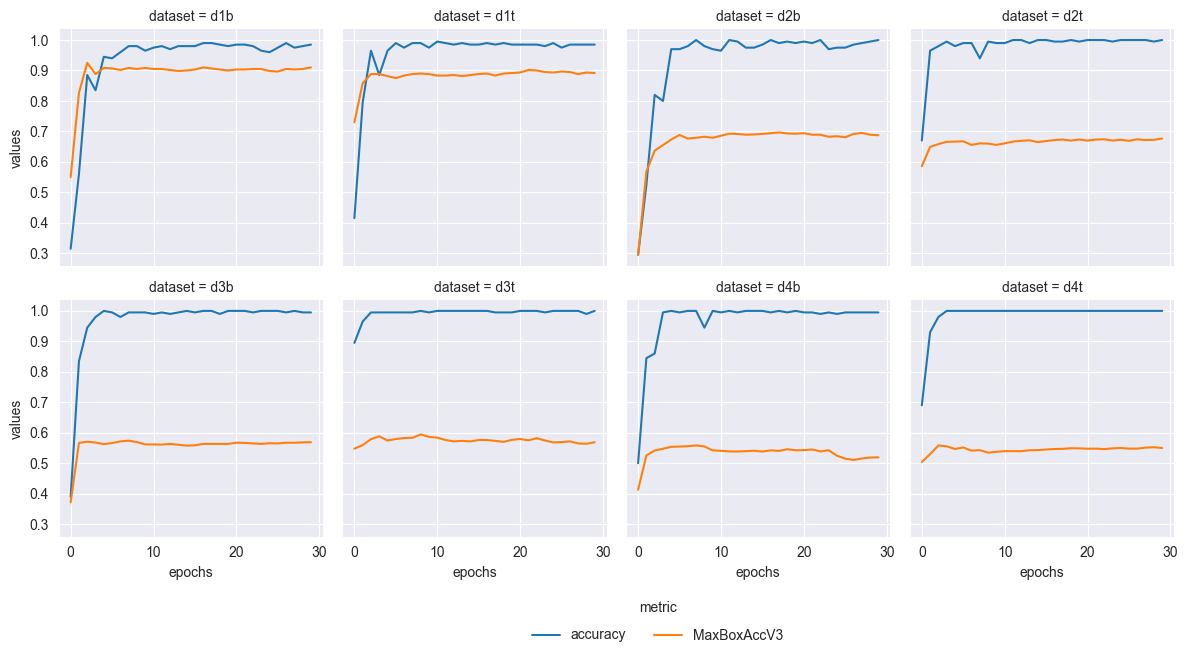

In [5]:
metric = 'MaxBoxAccV3'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.method': 'cam',
    'tags.train': 'True',
    'status': 'FINISHED'
}

df = mlflow_get_runs(experiment_name, conditions)

cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec', 'metrics.val_accuracy', 'metrics.val_MaxBoxAccV3', 'start_time']
cols_renamed = ['run_id', 'method', 'dataset', 'accuracy', 'MaxBoxAccV3', 'start_time']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
df = df.drop(columns='start_time')
df = df.assign(epochs=epoch_steps, accuracy=epoch_val_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']

data = df.sort_values('dataset')

sns.set_style("darkgrid")
# sns.set_context("paper")
hue_order = ['accuracy','MaxBoxAccV3']
# sns_plot = sns.relplot(data, x="epochs", y="values", hue="metric", col="dataset", col_wrap=4, kind="line")
g = sns.FacetGrid(data, col="dataset", hue="metric", hue_order=hue_order, col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()
sns.move_legend(g, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, labelspacing=1.0)
g.savefig(f'fig_loc_vs_acc_vgg16_gap_cam_synthetic.png')

### Classification versus Localization

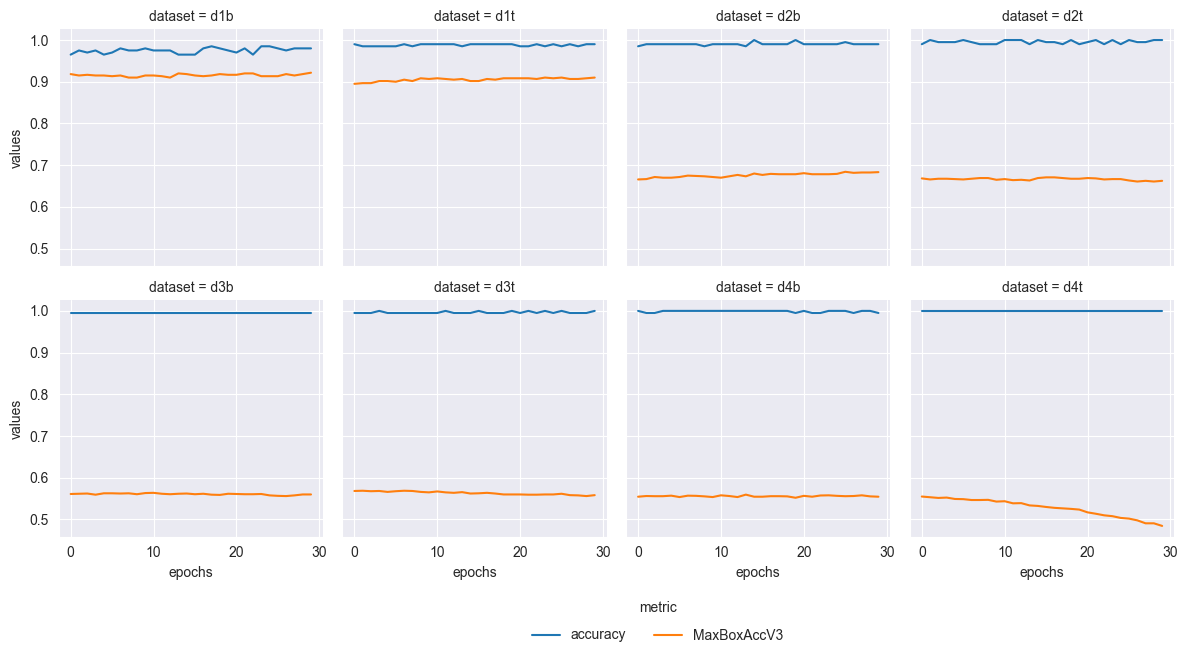

In [6]:
metric = 'MaxBoxAccV3'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.method': 'minmaxcam',
    'tags.train': 'True',
    'status': 'FINISHED'
}

df = mlflow_get_runs(experiment_name, conditions)

cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec', 'metrics.val_accuracy', 'metrics.val_MaxBoxAccV3', 'start_time']
cols_renamed = ['run_id', 'method', 'dataset', 'accuracy', 'MaxBoxAccV3', 'start_time']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
df = df.drop(columns='start_time')
df = df.assign(epochs=epoch_steps, accuracy=epoch_val_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']

data = df.sort_values('dataset')

sns.set_style("darkgrid")
hue_order = ['accuracy','MaxBoxAccV3']
g = sns.FacetGrid(data, col="dataset", hue="metric", hue_order=hue_order, col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()
sns.move_legend(g, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, labelspacing=1.0)
g.savefig(f'fig_loc_vs_acc_vgg16_gap_minmaxcam_synthetic.png')

### MaxBoxAccV3 recall

In [7]:
metric = 'MaxBoxAccV3_recall'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.label': 'gap',
    'status': 'FINISHED'
}
runs = mlflow_get_runs(experiment_name, conditions)
dataframe_to_latex(runs=runs, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_recall for VGG16-GAP on synthetic}
\label{tb:maxboxaccv3_recall_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_recall} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 91.50 & 91.17 & 67.33 & 66.92 & 59.33 & 58.33 & 48.58 & 54.00 \\
Grad-CAM++ & 92.67 & 90.67 & 68.50 & 67.75 & 60.17 & 57.83 & 49.12 & 53.04 \\
Score-CAM & 92.83 & 90.17 & 72.83 & 69.42 & 64.89 & 61.33 & 53.25 & 55.67 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_recall for VGG16-GAP on synthetic}
\label{tb:maxboxaccv3_recall_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_recall} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & \color{purple} \bfseries 91.50 & \color{teal} \bfseries 91.17 & \color{purple} \bfseries 67.33 & \color{purple} \bfserie

In [8]:
metric = 'MaxBoxAccV3_recall'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.label': 'minmaxcam',
    'status': 'FINISHED'
}
runs = mlflow_get_runs(experiment_name, conditions)
dataframe_to_latex(runs=runs, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_recall for VGG16-GAP on synthetic}
\label{tb:maxboxaccv3_recall_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_recall} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 91.67 & 92.00 & 67.00 & 66.33 & 59.11 & 57.17 & 53.25 & 47.67 \\
Grad-CAM++ & 94.17 & 93.67 & 67.50 & 67.00 & 59.94 & 57.17 & 54.46 & 49.62 \\
MinMaxCAM & 91.67 & 92.00 & 67.00 & 66.33 & 59.11 & 57.17 & 53.25 & 47.67 \\
Score-CAM & 95.00 & 93.50 & 73.75 & 70.83 & 64.83 & 61.22 & 61.37 & 57.96 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_recall for VGG16-GAP on synthetic}
\label{tb:maxboxaccv3_recall_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_recall} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & \color{purple} \bfseries 91.67 & \color{pur

### MaxBoxAccV3 precision

In [9]:
metric = 'MaxBoxAccV3_precision'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.label': 'gap',
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_precision for VGG16-GAP on synthetic}
\label{tb:maxboxaccv3_precision_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 85.16 & 85.78 & 72.72 & 71.52 & 67.91 & 65.07 & 59.15 & 63.10 \\
Grad-CAM++ & 85.95 & 85.97 & 73.27 & 71.69 & 67.08 & 64.03 & 58.24 & 61.36 \\
Score-CAM & 84.91 & 83.40 & 75.42 & 72.33 & 70.46 & 66.94 & 61.62 & 63.35 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_precision for VGG16-GAP on synthetic}
\label{tb:maxboxaccv3_precision_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & 85.16 & 85.78 & \color{purple} \bfseries 72.72 & \color{purple} \bfseries 71.52 & 67.91 & 65.07 & 59.1

In [10]:
metric = 'MaxBoxAccV3_precision'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.label': 'minmaxcam',
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_precision for VGG16-GAP on synthetic}
\label{tb:maxboxaccv3_precision_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 86.26 & 86.54 & 71.76 & 70.90 & 67.23 & 66.16 & 65.96 & 57.56 \\
Grad-CAM++ & 89.84 & 89.73 & 71.59 & 70.82 & 66.45 & 65.97 & 64.54 & 58.59 \\
MinMaxCAM & 86.26 & 86.54 & 71.76 & 70.90 & 67.23 & 66.16 & 65.96 & 57.56 \\
Score-CAM & 88.40 & 88.28 & 76.38 & 72.84 & 70.22 & 67.07 & 68.30 & 65.22 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_precision for VGG16-GAP on synthetic}
\label{tb:maxboxaccv3_precision_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & \color{purple} \bfseries 

### PxAP

In [11]:
metric = 'PxAP'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.label': 'gap',
    'status': 'FINISHED'
}
# conditions |= {
#     'tags.dataset_spec': 'd4b'
# }
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{PxAP for VGG16-GAP on synthetic}
\label{tb:pxap_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 79.89 & 83.12 & 77.41 & 78.54 & 74.37 & 71.37 & 66.02 & 71.37 \\
Grad-CAM++ & 80.82 & 83.81 & 78.82 & 79.12 & 75.97 & 71.27 & 66.72 & 71.22 \\
Score-CAM & 79.51 & 82.79 & 76.57 & 76.23 & 75.36 & 73.06 & 67.38 & 72.47 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{PxAP for VGG16-GAP on synthetic}
\label{tb:pxap_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & 79.89 & 83.12 & 77.41 & 78.54 & \color{purple} \bfseries 74.37 & 71.37 & \color{purple} \bfseries 66.02 & 71.37 \\
Grad-CAM++ & \color{teal} \bfseries 80.82 & \color{teal} \bfseries 83.81 & \color{teal} \

In [12]:
metric = 'PxAP'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.label': 'minmaxcam',
    'status': 'FINISHED'
}
# conditions |= {
#     'tags.dataset_spec': 'd4b'
# }
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{PxAP for VGG16-GAP on synthetic}
\label{tb:pxap_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 82.93 & 82.80 & 77.65 & 77.39 & 74.39 & 72.28 & 70.91 & 64.78 \\
Grad-CAM++ & 84.13 & 84.26 & 79.10 & 78.45 & 75.76 & 72.66 & 72.93 & 68.22 \\
MinMaxCAM & 82.93 & 82.80 & 77.65 & 77.39 & 74.39 & 72.28 & 70.91 & 64.78 \\
Score-CAM & 82.83 & 84.65 & 77.66 & 77.30 & 75.61 & 74.31 & 75.48 & 75.14 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{PxAP for VGG16-GAP on synthetic}
\label{tb:pxap_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & 82.93 & \color{purple} \bfseries 82.80 & \color{purple} \bfseries 77.65 & 77.39 & \color{purple} \bfseries 74.39 & \color{purpl

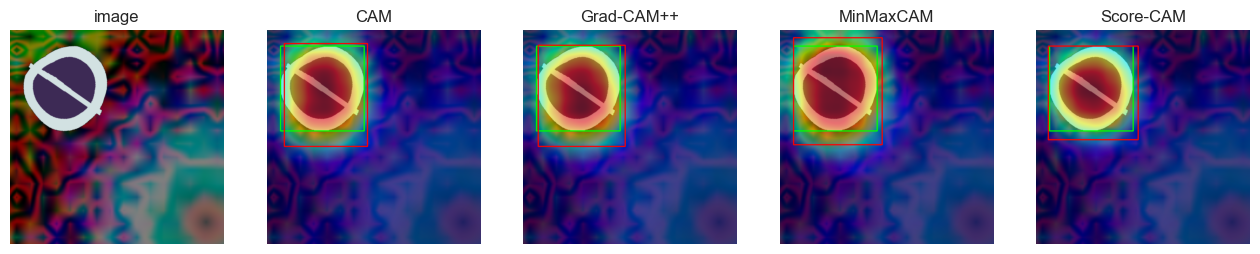

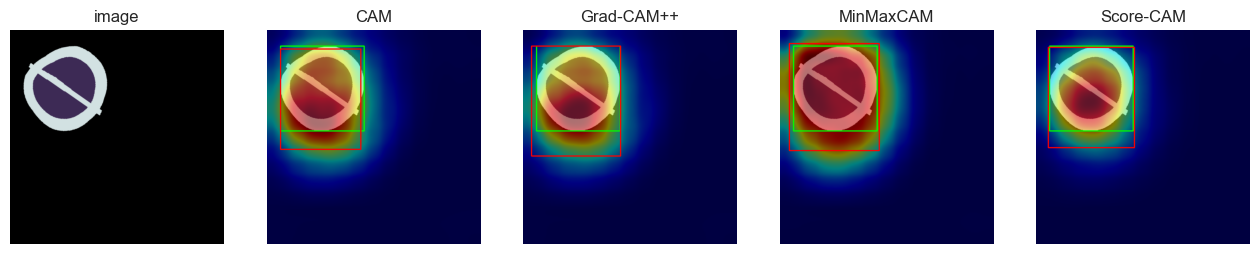

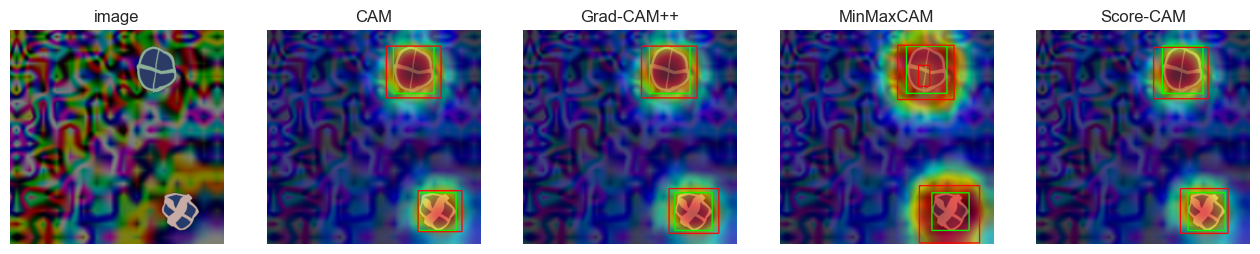

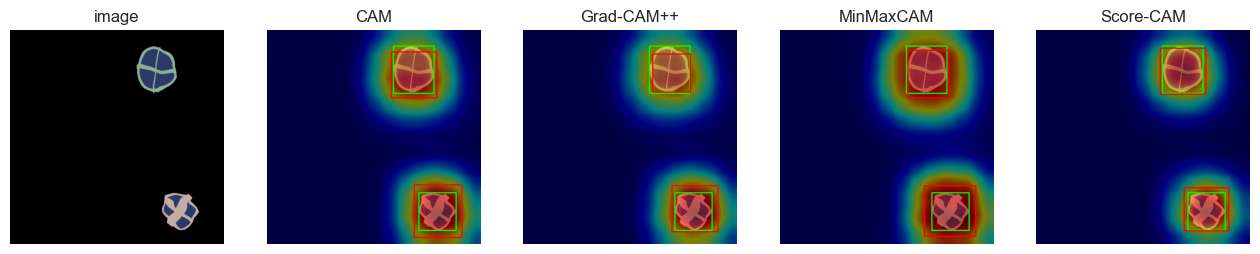

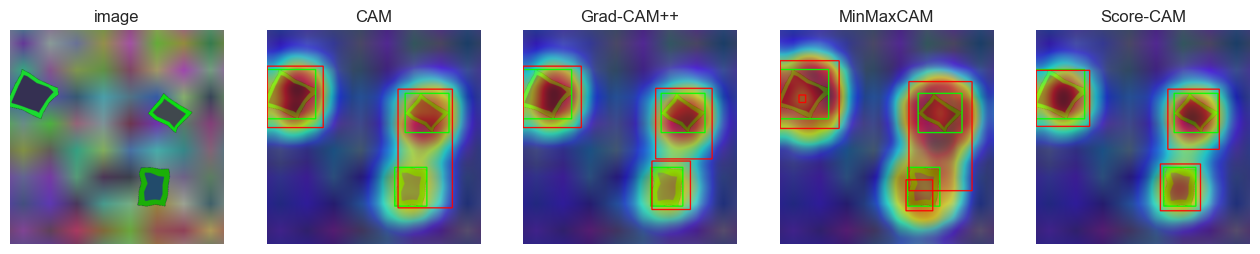

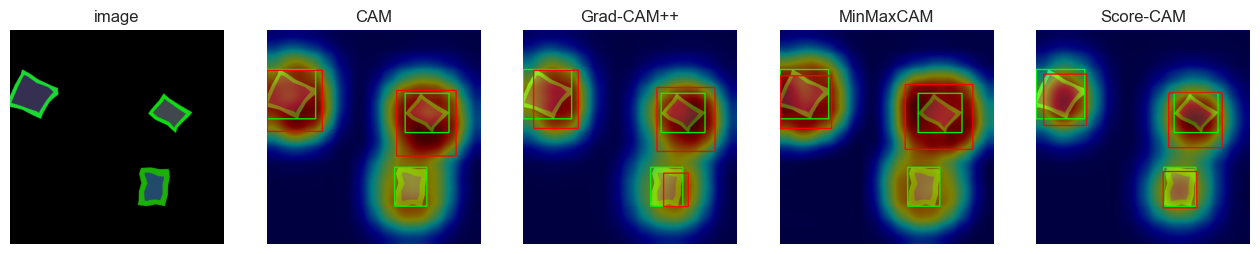

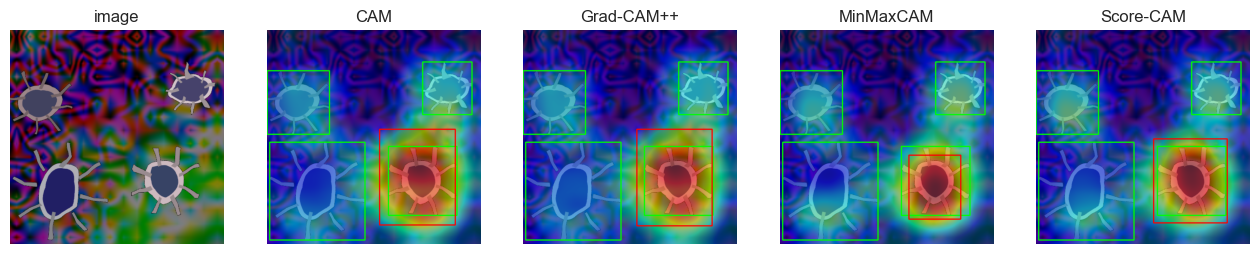

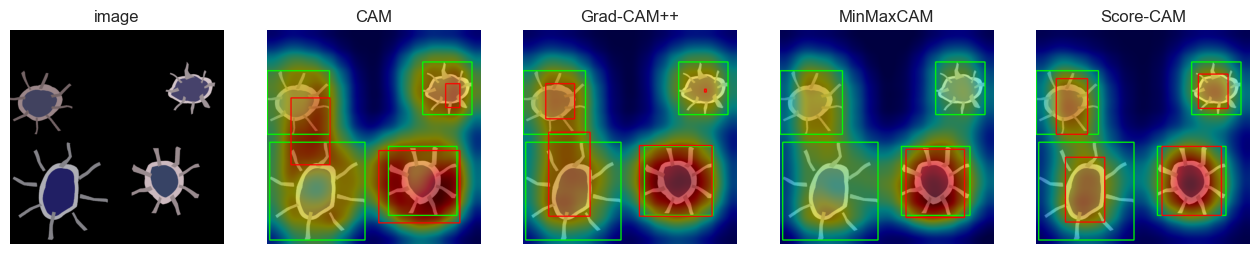

In [13]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image

split = 'test'
image_id = 10
iter = 0
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol2_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.label': 'minmaxcam',
    'status': 'FINISHED'
}
df = mlflow_get_runs(experiment_name, conditions)
df.loc[:, 'artifact_uri'] = df['artifact_uri'].str.removeprefix('file://')

speclist = sorted(df['tags.dataset_spec'].unique())
for spec in speclist:
    df_spec = df.loc[df['tags.dataset_spec'] == spec]
    df_spec = df_spec.loc[:, ['tags.method', 'tags.dataset_spec', 'artifact_uri']]
    df_spec = df_spec.sort_values('tags.method')
    spec_dict = df_spec.set_index('tags.method').to_dict()
    uris = spec_dict['artifact_uri']
    spec = '_'.join(list(spec))
    filebase = f'SYNTHETIC_{spec}_test_{image_id}'
    file_img = filebase + f'_img_{iter}.png'
    file_ann = filebase + f'_ann_{iter}.png'
    file_cam = filebase + f'_cam_{iter}.png'
    file_seg = filebase + f'_seg_{iter}.png'
    path_img_orig = os.path.join(f'/Users/goemaereg/github.com/thesis/data/dataset/SYNTHETIC/{spec}/{split}/SYNTHETIC_{spec}_{split}_{image_id}.png')
    _, axes = plt.subplots(1, len(uris) + 1, figsize=(16, 8))
    img = read_image(path=path_img_orig)
    axes[0].imshow(to_pil_image(img))
    axes[0].axis('off')
    axes[0].set_title('image')
    for i, (method, uri) in enumerate(uris.items()):
        path_img = os.path.join(uri, 'xai', split, file_ann)
        img = read_image(path=path_img)
        axes[i+1].imshow(to_pil_image(img))
        axes[i+1].axis('off')
        axes[i+1].set_title(labels_methods[method])
    plt.show()

### Localization performance at varying CAM thresholds

In [14]:
path_basedir = '../train_log'
methods = ['cam', 'gradcam++', 'scorecam', 'minmaxcam']
background_filter = 'b'

In [15]:
experiment_name = 'mwsol_vgg16_synthetic'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
runs = mlflow_get_runs(experiment_name, conditions=conditions)
runs = runs.loc[runs['tags.dataset_spec'].str.contains(background_filter)]

In [16]:
runs

run_id       experiment_id    status   
0   25efa11783df4218a9d57bd166cea872  998329977809601835  FINISHED  \
2   c844b03070df4759b7cef556bea5f396  998329977809601835  FINISHED   
4   f9bc1986e4bb4f57b6c9741fb695d114  998329977809601835  FINISHED   
6   0ed45a04bcd249cf818faac31bcfb3df  998329977809601835  FINISHED   
8   4a5f8a55182a4265a6568624a5bc1630  998329977809601835  FINISHED   
10  4536131124ac45418896364fbcbc0814  998329977809601835  FINISHED   
12  eac8230f6acc413eb85da3e3149305d3  998329977809601835  FINISHED   
14  c0698ce23454462291227590edbde23f  998329977809601835  FINISHED   
16  1f744062b33d42b68bb8640e5ddb6f27  998329977809601835  FINISHED   
18  d87c933d60bb4ce7b40abd0b0a230566  998329977809601835  FINISHED   
20  367c6d159fde4218ae099dfd80d020a5  998329977809601835  FINISHED   
22  5b11831472dd4c80b8c95b52e07fc7b1  998329977809601835  FINISHED   
24  3e707bcb55a446b99d33ff7afcfa12ec  998329977809601835  FINISHED   
26  f96710fc1ec54ab0b0d5a9a4cbca1ad3  998329977809601835  FINISHED   
28  46ad4d2bf900458ab4c3318d4b9b6701  998329977809601835  FINISHED   
30  1c4a6b5954954f51907e068c0021f7b2  998329977809601835  FINISHED   

                                         artifact_uri   
0   file:///Users/goemaereg/github.com/thesis/mlru...  \
2   file:///Users/goemaereg/github.com/thesis/mlru...   
4   file:///Users/goemaereg/github.com/thesis/mlru...   
6   file:///Users/goemaereg/github.com/thesis/mlru...   
8   file:///Users/goemaereg/github.com/thesis/mlru...   
10  file:///Users/goemaereg/github.com/thesis/mlru...   
12  file:///Users/goemaereg/github.com/thesis/mlru...   
14  file:///Users/goemaereg/github.com/thesis/mlru...   
16  file:///Users/goemaereg/github.com/thesis/mlru...   
18  file:///Users/goemaereg/github.com/thesis/mlru...   
20  file:///Users/goemaereg/github.com/thesis/mlru...   
22  file:///Users/goemaereg/github.com/thesis/mlru...   
24  file:///Users/goemaereg/github.com/thesis/mlru...   
26  file:///Users/goemaereg/github.com/thesis/mlru...   
28  file:///Users/goemaereg/github.com/thesis/mlru...   
30  file:///Users/goemaereg/github.com/thesis/mlru...   

                         start_time                         end_time   
0  2023-04-04 18:02:18.438000+00:00 2023-04-04 18:07:34.874000+00:00  \
2  2023-04-04 16:21:55.409000+00:00 2023-04-04 16:28:22.927000+00:00   
4  2023-04-04 14:27:10.311000+00:00 2023-04-04 14:37:50.396000+00:00   
6  2023-04-04 12:42:06.321000+00:00 2023-04-04 12:47:32.161000+00:00   
8  2023-04-02 15:01:00.532000+00:00 2023-04-02 15:22:33.433000+00:00   
10 2023-04-02 14:10:22.695000+00:00 2023-04-02 14:32:04.952000+00:00   
12 2023-04-02 13:18:18.054000+00:00 2023-04-02 13:39:29.086000+00:00   
14 2023-04-02 12:55:56.120000+00:00 2023-04-02 13:17:32.581000+00:00   
16 2023-04-02 12:23:56.424000+00:00 2023-04-02 12:25:03.838000+00:00   
18 2023-04-02 12:22:59.001000+00:00 2023-04-02 12:24:06.544000+00:00   
20 2023-04-02 12:22:06.224000+00:00 2023-04-02 12:23:08.107000+00:00   
22 2023-04-02 12:21:15.040000+00:00 2023-04-02 12:22:37.491000+00:00   
24 2023-04-02 06:19:32.959000+00:00 2023-04-02 06:31:31.646000+00:00   
26 2023-04-02 05:52:43.786000+00:00 2023-04-02 06:00:57.129000+00:00   
28 2023-04-02 05:20:29.836000+00:00 2023-04-02 05:30:20.511000+00:00   
30 2023-04-01 19:29:25.002000+00:00 2023-04-01 19:42:46.095000+00:00   

    metrics.test_MaxBoxAcc_recall_IOU_70  metrics.test_MaxBoxAcc_precision   
0                                  0.485                             0.920  \
2                                  0.635                             0.945   
4                                  0.530                             0.940   
6                                  0.865                             0.975   
8                                  0.480                             0.915   
10                                 0.610                             0.925   
12                                 0.525                             0.935   
14                  

In [17]:
runs.loc[:, ['tags.method', 'tags.architecture', 'tags.dataset', 'tags.dataset_spec', 'artifact_uri']]

tags.method tags.architecture tags.dataset tags.dataset_spec   
0    minmaxcam             vgg16    SYNTHETIC               d4b  \
2    minmaxcam             vgg16    SYNTHETIC               d3b   
4    minmaxcam             vgg16    SYNTHETIC               d2b   
6    minmaxcam             vgg16    SYNTHETIC               d1b   
8     scorecam             vgg16    SYNTHETIC               d4b   
10    scorecam             vgg16    SYNTHETIC               d3b   
12    scorecam             vgg16    SYNTHETIC               d2b   
14    scorecam             vgg16    SYNTHETIC               d1b   
16   gradcam++             vgg16    SYNTHETIC               d4b   
18   gradcam++             vgg16    SYNTHETIC               d3b   
20   gradcam++             vgg16    SYNTHETIC               d2b   
22   gradcam++             vgg16    SYNTHETIC               d1b   
24         cam             vgg16    SYNTHETIC               d4b   
26         cam             vgg16    SYNTHETIC               d3b   
28         cam             vgg16    SYNTHETIC               d2b   
30         cam             vgg16    SYNTHETIC               d1b   

                                         artifact_uri  
0   file:///Users/goemaereg/github.com/thesis/mlru...  
2   file:///Users/goemaereg/github.com/thesis/mlru...  
4   file:///Users/goemaereg/github.com/thesis/mlru...  
6   file:///Users/goemaereg/github.com/thesis/mlru...  
8   file:///Users/goemaereg/github.com/thesis/mlru...  
10  file:///Users/goemaereg/github.com/thesis/mlru...  
12  file:///Users/goemaereg/github.com/thesis/mlru...  
14  file:///Users/goemaereg/github.com/thesis/mlru...  
16  file:///Users/goemaereg/github.com/thesis/mlru...  
18  file:///Users/goemaereg/github.com/thesis/mlru...  
20  file:///Users/goemaereg/github.com/thesis/mlru...  
22  file:///Users/goemaereg/github.com/thesis/mlru...  
24  file:///Users/goemaereg/github.com/thesis/mlru...  
26  file:///Users/goemaereg/github.com/thesis/mlru...  
28  file:///Users/goemaereg/github.com/thesis/mlru...  
30  file:///Users/goemaereg/github.com/thesis/mlru...

## VGG16 vanilla

### MaxBoxAccV3 recall

In [18]:
metric = 'MaxBoxAccV3_recall'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'vanilla'
network = 'VGG16'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.label': 'base',
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_recall for VGG16 on synthetic}
\label{tb:maxboxaccv3_recall_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_recall} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
Grad-CAM & 81.33 & 68.83 & 51.17 & 46.08 & 46.94 & 45.06 & 45.33 & 44.00 \\
Grad-CAM++ & 72.17 & 66.83 & 37.58 & 35.58 & 36.33 & 31.94 & 35.29 & 38.75 \\
Score-CAM & 77.50 & 69.33 & 55.33 & 49.42 & 50.50 & 49.50 & 48.08 & 46.79 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_recall for VGG16 on synthetic}
\label{tb:maxboxaccv3_recall_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_recall} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
Grad-CAM & \color{teal} \bfseries 81.33 & 68.83 & 51.17 & 46.08 & 46.94 & 45.06 & 45.33 & 44.00 \\
Grad-CAM++ & \color{purple} \b

### MaxBoxAccV3 precision

In [40]:
metric = 'MaxBoxAccV3_precision'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'vanilla'
network = 'VGG16'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_precision for VGG16 on synthetic}
\label{tb:maxboxaccv3_precision_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
Grad-CAM & 53.29 & 43.62 & 53.78 & 46.13 & 47.38 & 44.70 & 47.99 & 48.13 \\
Grad-CAM++ & 29.51 & 29.45 & 32.24 & 29.36 & 31.81 & 25.84 & 31.01 & 35.49 \\
Score-CAM & 54.05 & 47.01 & 58.24 & 51.22 & 52.48 & 52.10 & 52.36 & 53.33 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_precision for VGG16 on synthetic}
\label{tb:maxboxaccv3_precision_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
Grad-CAM & 53.29 & 43.62 & 53.78 & 46.13 & 47.38 & 44.70 & 47.99 & 48.13 \\
Grad-CAM++ & \color{purple} \bfseri

### PxAP

In [41]:
metric = 'PxAP'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'vanilla'
network = 'VGG16'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{PxAP for VGG16 on synthetic}
\label{tb:pxap_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
Grad-CAM & 69.83 & 59.06 & 57.35 & 45.12 & 51.73 & 52.00 & 56.18 & 54.84 \\
Grad-CAM++ & 63.92 & 58.11 & 42.26 & 34.54 & 44.73 & 38.77 & 46.06 & 47.34 \\
Score-CAM & 66.44 & 60.73 & 59.32 & 52.59 & 58.39 & 59.53 & 58.25 & 58.74 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{PxAP for VGG16 on synthetic}
\label{tb:pxap_vgg16_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
Grad-CAM & \color{teal} \bfseries 69.83 & 59.06 & 57.35 & 45.12 & 51.73 & 52.00 & 56.18 & 54.84 \\
Grad-CAM++ & \color{purple} \bfseries 63.92 & \color{purple} \bfseries 58.11 & \color{purple} \bfseries 42.26 & \c

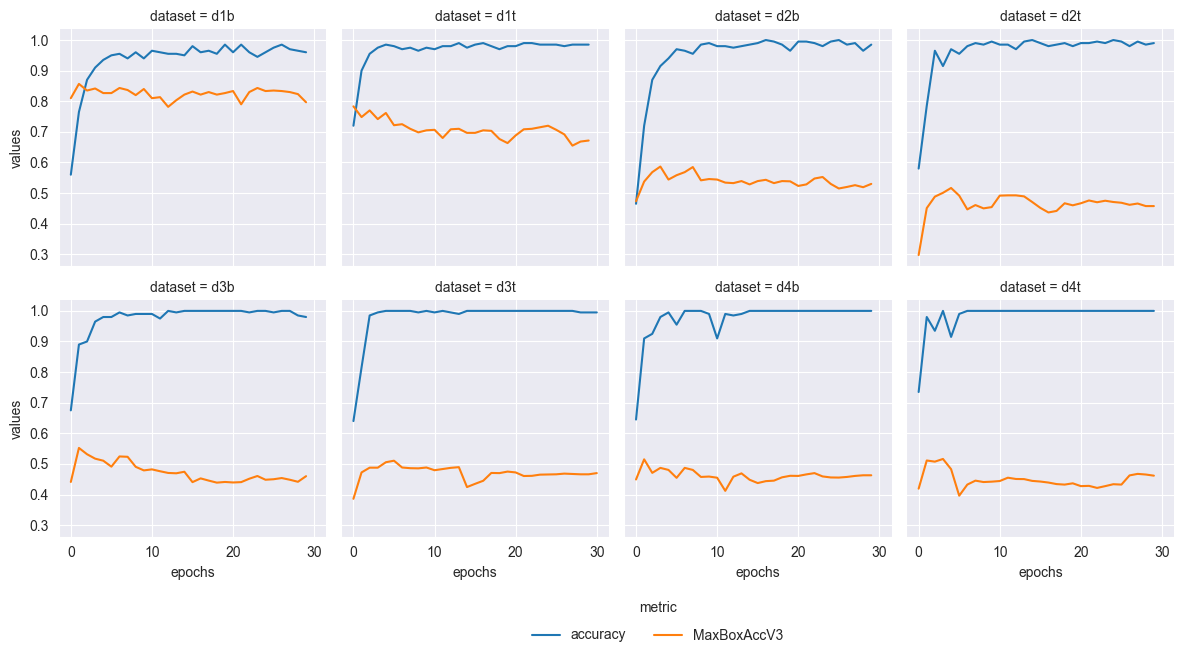

In [55]:
metric = 'MaxBoxAccV3'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'vanilla'
network = 'VGG16'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.method': 'gradcam',
    'status': 'FINISHED'
}

df = mlflow_get_runs(experiment_name, conditions)

cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec']
cols_renamed = ['run_id', 'method', 'dataset']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
df = df.assign(epochs=epoch_steps, accuracy=epoch_val_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']

data = df.sort_values('dataset')

sns.set_style("darkgrid")
# sns.set_context("paper")
hue_order = ['accuracy','MaxBoxAccV3']
# sns_plot = sns.relplot(data, x="epochs", y="values", hue="metric", col="dataset", col_wrap=4, kind="line")
g = sns.FacetGrid(data, col="dataset", hue="metric", hue_order=hue_order, col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()
sns.move_legend(g, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, labelspacing=1.0)
# g.savefig(f'fig_loc_vs_acc_vgg16_base_cam_synthetic.png')

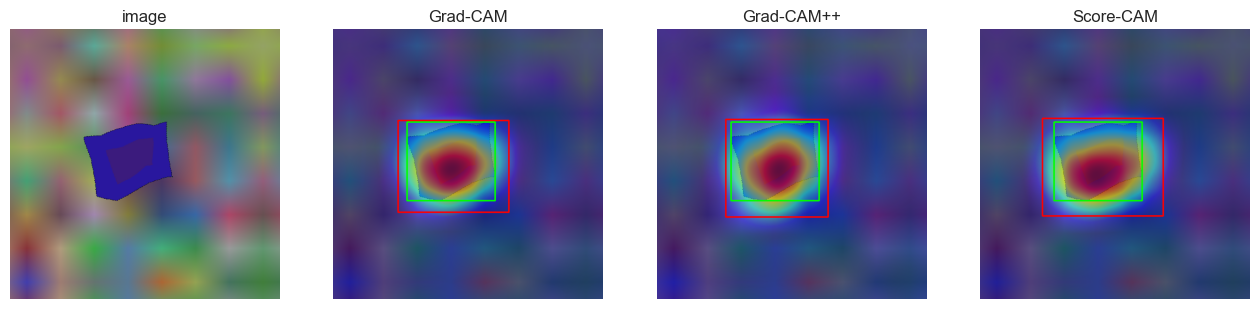

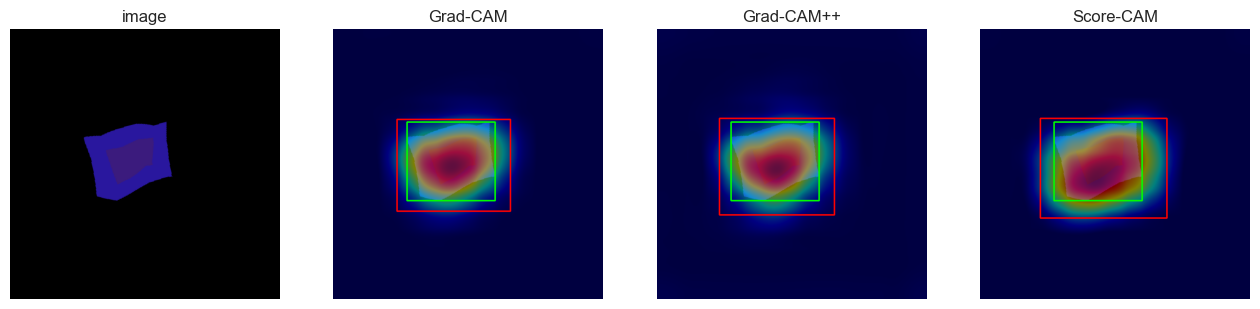

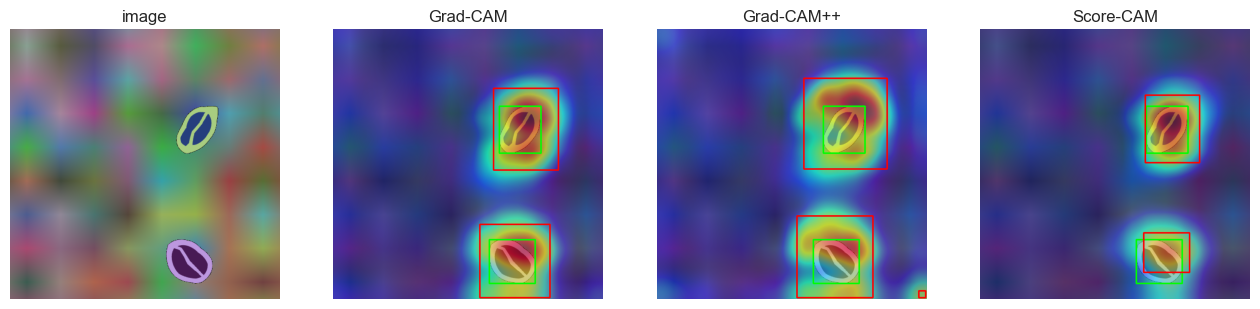

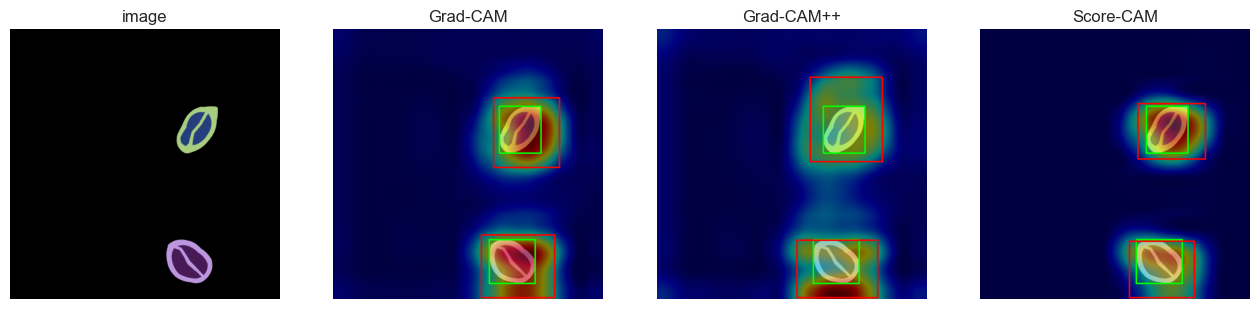

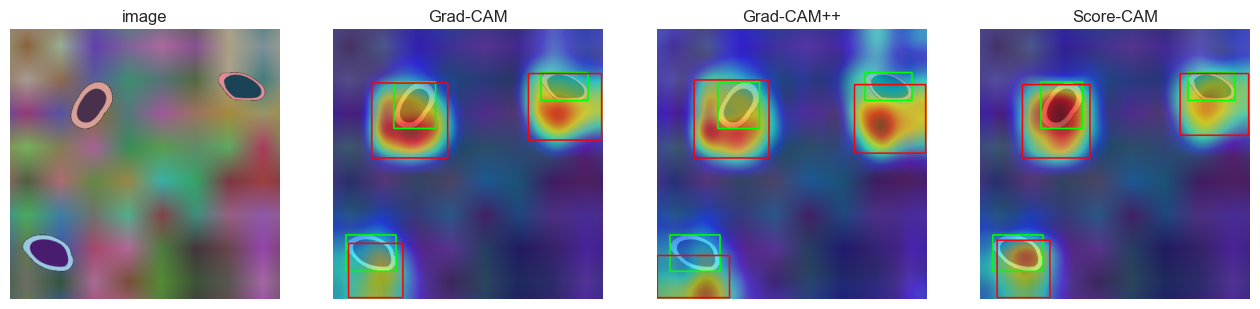

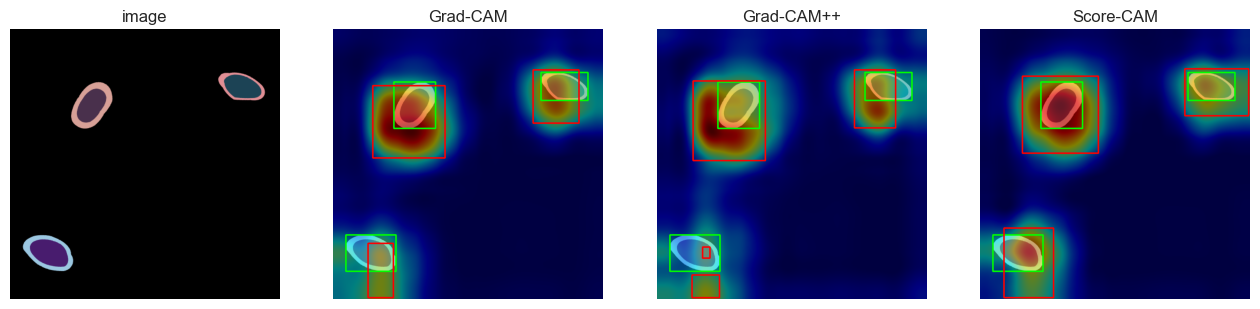

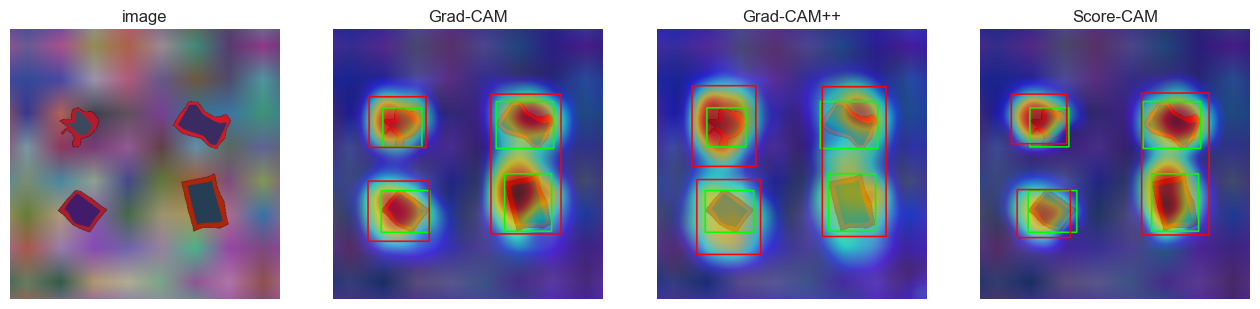

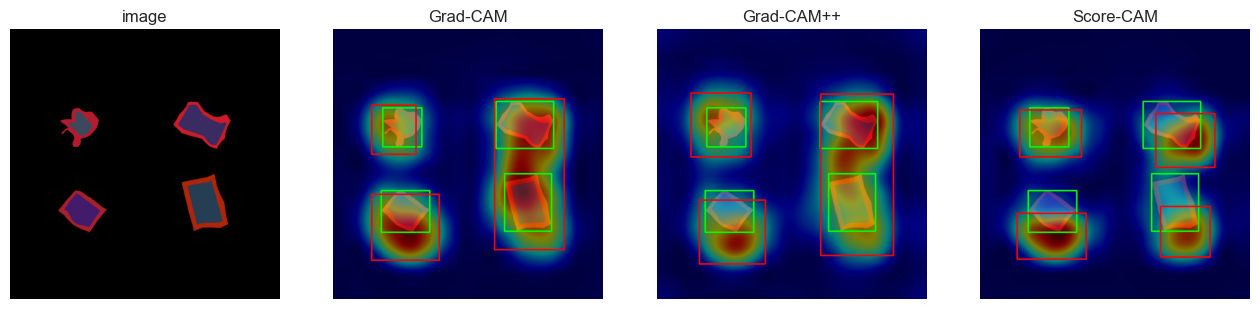

In [51]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image

split = 'test'
image_id = 2
iter = 0
metric = 'MaxBoxAccV3'
metric_name = metric if metric is not None else 'Metrics'
arch = 'vgg16'
arch_type = 'vanilla'
network = 'VGG16'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
df = mlflow_get_runs(experiment_name, conditions)
df.loc[:, 'artifact_uri'] = df['artifact_uri'].str.removeprefix('file://')

for spec in sorted(df['tags.dataset_spec'].unique()):
    df_spec = df.loc[df['tags.dataset_spec'] == spec]
    df_spec = df_spec.loc[:, ['tags.method', 'tags.dataset_spec', 'artifact_uri']]
    spec_dict = df_spec.set_index('tags.method').sort_index().to_dict()
    uris = spec_dict['artifact_uri']
    spec = '_'.join(list(spec))
    filebase = f'SYNTHETIC_{spec}_test_{image_id}'
    file_img = filebase + f'_img_{iter}.png'
    file_ann = filebase + f'_ann_{iter}.png'
    path_img_orig = os.path.join(f'/Users/goemaereg/github.com/thesis/data/dataset/SYNTHETIC/{spec}/{split}/SYNTHETIC_{spec}_{split}_{image_id}.png')
    _, axes = plt.subplots(1, 4, figsize=(16, 8))
    img = read_image(path=path_img_orig)
    axes[0].imshow(to_pil_image(img))
    axes[0].axis('off')
    axes[0].set_title('image')
    for i, (method, uri) in enumerate(uris.items()):
        path_img = os.path.join(uri, 'xai', split, file_ann)
        img = read_image(path=path_img)
        axes[i+1].imshow(to_pil_image(img))
        axes[i+1].axis('off')
        axes[i+1].set_title(labels_methods[method])
    plt.show()

## ResNet-50

### Classificaton versus Localization

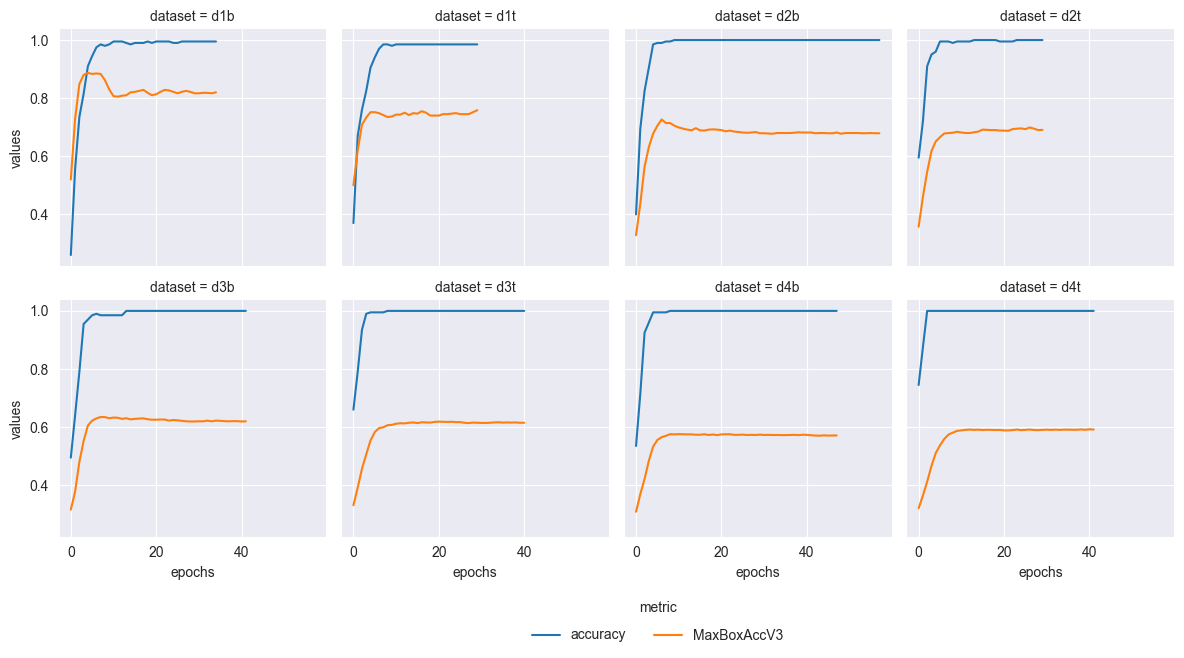

In [59]:
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.method': 'cam',
    'tags.label': 'gap',
    'tags.train': 'True',
    'status': 'FINISHED'
}

df = mlflow_get_runs(experiment_name, conditions)

cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec', 'metrics.val_accuracy', 'metrics.val_MaxBoxAccV3', 'start_time']
cols_renamed = ['run_id', 'method', 'dataset', 'accuracy', 'MaxBoxAccV3', 'start_time']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
df = df.drop(columns='start_time')
df = df.assign(epochs=epoch_steps, accuracy=epoch_val_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']

data = df.sort_values('dataset')

sns.set_style("darkgrid")
hue_order = ['accuracy','MaxBoxAccV3']
g = sns.FacetGrid(data, col="dataset", hue="metric", hue_order=hue_order, col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()
sns.move_legend(g, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, labelspacing=1.0)
g.savefig(f'fig_loc_vs_acc_vgg16_gap_minmaxcam_synthetic.png')

### MaxBoxAccV3 recall

#### non-regularized

In [60]:
metric = 'MaxBoxAccV3_recall'
metric_name = metric if metric is not None else 'Metrics'
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.label': 'gap',
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_recall for ResNet-50 on synthetic}
\label{tb:maxboxaccv3_recall_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_recall} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 84.00 & 74.67 & 67.08 & 71.08 & 62.89 & 62.61 & 59.29 & 58.71 \\
Grad-CAM++ & 85.33 & 75.67 & 69.33 & 72.08 & 66.06 & 65.00 & 61.79 & 61.13 \\
Score-CAM & 85.50 & 77.00 & 68.92 & 73.58 & 64.89 & 65.50 & 61.63 & 60.58 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_recall for ResNet-50 on synthetic}
\label{tb:maxboxaccv3_recall_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_recall} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & \color{purple} \bfseries 84.00 & \color{purple} \bfseries 74.67 & \color{purple} \bfseries 67.08 & \color{purple} 

#### MaxBoxAccV3-regularized

In [61]:
metric = 'MaxBoxAccV3_recall'
metric_name = metric if metric is not None else 'Metrics'
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.label': 'minmaxcam',
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_recall for ResNet-50 on synthetic}
\label{tb:maxboxaccv3_recall_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_recall} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 80.33 & 68.17 & 59.17 & 59.08 & 56.50 & 56.11 & 55.92 & 52.87 \\
Grad-CAM++ & 80.83 & 69.17 & 63.83 & 61.92 & 61.00 & 59.94 & 58.96 & 57.08 \\
MinMaxCAM & 80.33 & 68.17 & 59.17 & 59.08 & 56.50 & 56.11 & 55.92 & 52.87 \\
Score-CAM & 79.00 & 71.17 & 61.00 & 62.50 & 58.44 & 59.11 & 58.71 & 56.83 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_recall for ResNet-50 on synthetic}
\label{tb:maxboxaccv3_recall_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_recall} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & 80.33 & \color{purple} \bfseries 68.1

### MaxBoxAccV3 precision

#### non-regularized

In [62]:
metric = 'MaxBoxAccV3_precision'
metric_name = metric if metric is not None else 'Metrics'
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,c
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.label': 'gap',
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_precision for ResNet-50 on synthetic}
\label{tb:maxboxaccv3_precision_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 75.30 & 59.95 & 69.48 & 73.63 & 68.29 & 66.17 & 65.83 & 65.50 \\
Grad-CAM++ & 76.75 & 61.45 & 70.99 & 73.84 & 70.14 & 67.96 & 66.94 & 66.57 \\
Score-CAM & 77.58 & 64.77 & 69.51 & 74.60 & 69.25 & 68.70 & 67.75 & 65.82 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_precision for ResNet-50 on synthetic}
\label{tb:maxboxaccv3_precision_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & \color{purple} \bfseries 75.30 & \color{purple} \bfseries 59.95 & \color{purple} \bfseries 69.48

#### MinMaxCAM-regularized

In [63]:
metric = 'MaxBoxAccV3_precision'
metric_name = metric if metric is not None else 'Metrics'
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.label': 'minmaxcam',
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{MaxBoxAccV3_precision for ResNet-50 on synthetic}
\label{tb:maxboxaccv3_precision_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 70.21 & 49.82 & 61.23 & 60.03 & 61.27 & 59.88 & 62.59 & 58.82 \\
Grad-CAM++ & 71.31 & 53.73 & 64.93 & 62.81 & 63.74 & 62.68 & 63.85 & 61.90 \\
MinMaxCAM & 70.21 & 49.82 & 61.23 & 60.03 & 61.27 & 59.88 & 62.59 & 58.82 \\
Score-CAM & 68.87 & 55.41 & 61.61 & 62.07 & 62.13 & 62.09 & 63.64 & 61.30 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{MaxBoxAccV3_precision for ResNet-50 on synthetic}
\label{tb:maxboxaccv3_precision_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{MaxBoxAccV3_precision} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & 70.21 & \color{purp

### PxAP

#### non-regularized

In [64]:
metric = 'PxAP'
metric_name = metric if metric is not None else 'Metrics'
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.label': 'gap',
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{PxAP for ResNet-50 on synthetic}
\label{tb:pxap_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 76.85 & 65.98 & 75.60 & 77.27 & 75.32 & 73.97 & 74.00 & 71.46 \\
Grad-CAM++ & 78.02 & 68.86 & 76.97 & 78.03 & 76.93 & 74.69 & 75.31 & 72.10 \\
Score-CAM & 77.97 & 69.36 & 76.09 & 79.37 & 74.63 & 75.58 & 72.83 & 72.92 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{PxAP for ResNet-50 on synthetic}
\label{tb:pxap_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & \color{purple} \bfseries 76.85 & \color{purple} \bfseries 65.98 & \color{purple} \bfseries 75.60 & \color{purple} \bfseries 77.27 & 75.32 & \color{purple} \bfseries 73.97 & 74.00 & \color{purple} \b

#### MinMaxCAM-regularized

In [65]:
metric = 'PxAP'
metric_name = metric if metric is not None else 'Metrics'
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol3_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'tags.label': 'minmaxcam',
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=[metric], caption=caption, label=label)

\begin{table}[ht]
\caption{PxAP for ResNet-50 on synthetic}
\label{tb:pxap_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
CAM & 71.11 & 56.26 & 63.38 & 66.11 & 67.64 & 66.99 & 68.71 & 64.74 \\
Grad-CAM++ & 72.56 & 59.92 & 66.74 & 68.09 & 70.15 & 69.25 & 70.83 & 66.89 \\
MinMaxCAM & 71.11 & 56.26 & 63.38 & 66.11 & 67.64 & 66.99 & 68.71 & 64.74 \\
Score-CAM & 71.43 & 61.04 & 65.57 & 68.20 & 67.23 & 68.20 & 69.15 & 67.20 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{PxAP for ResNet-50 on synthetic}
\label{tb:pxap_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
CAM & \color{purple} \bfseries 71.11 & \color{purple} \bfseries 56.26 & \color{purple} \bfseries 63.38 & \color{purple} \bfseri

#### Explanation examples

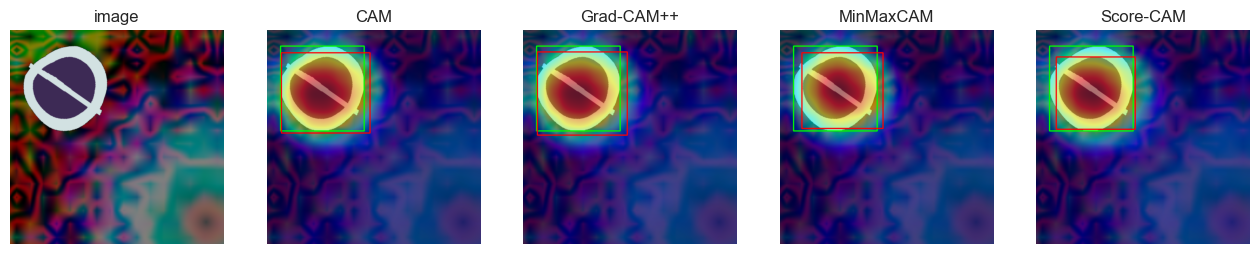

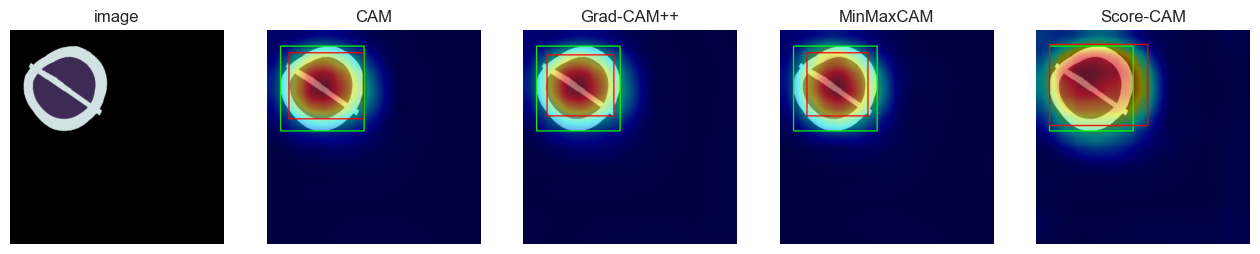

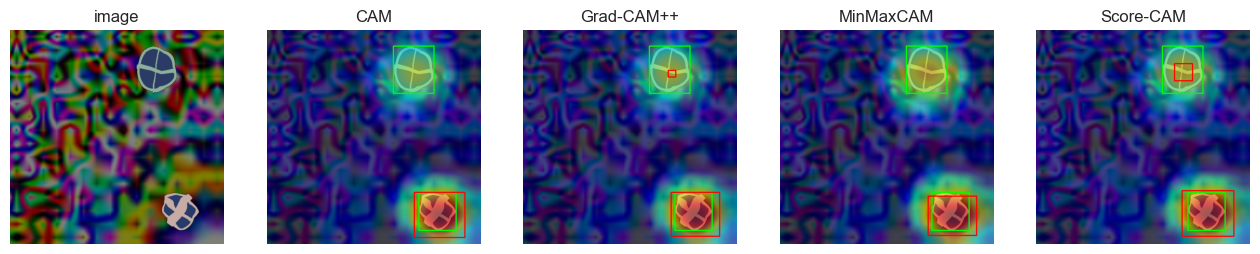

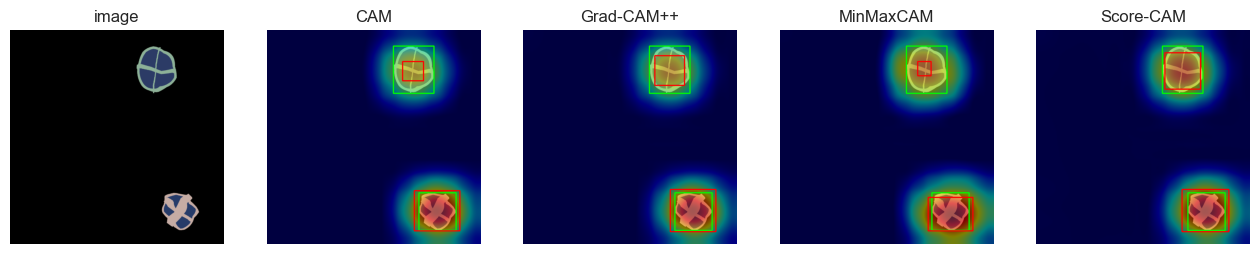

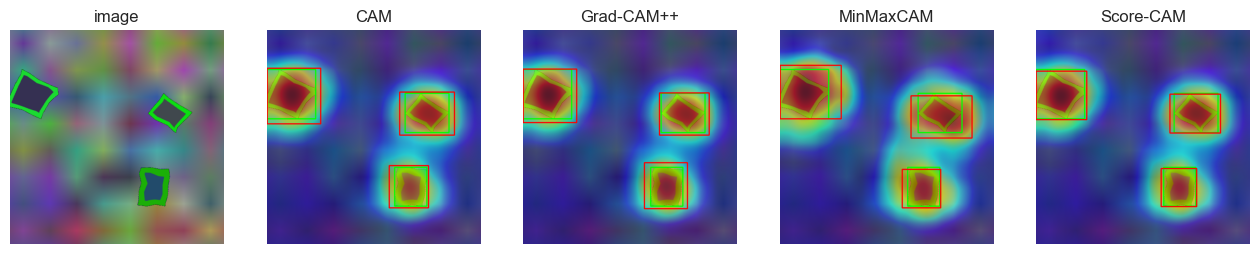

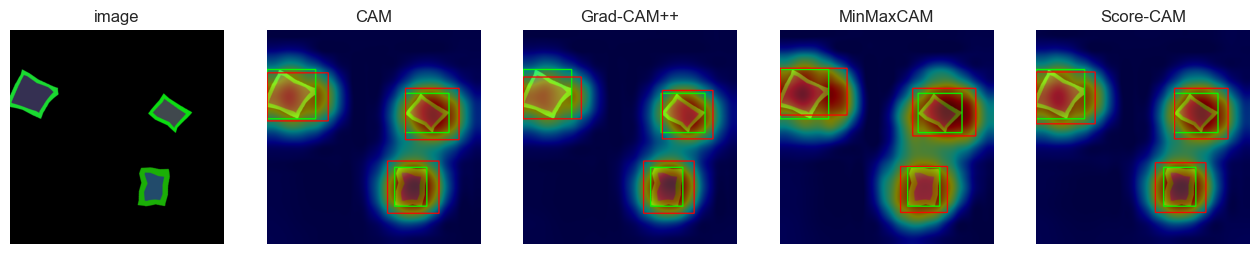

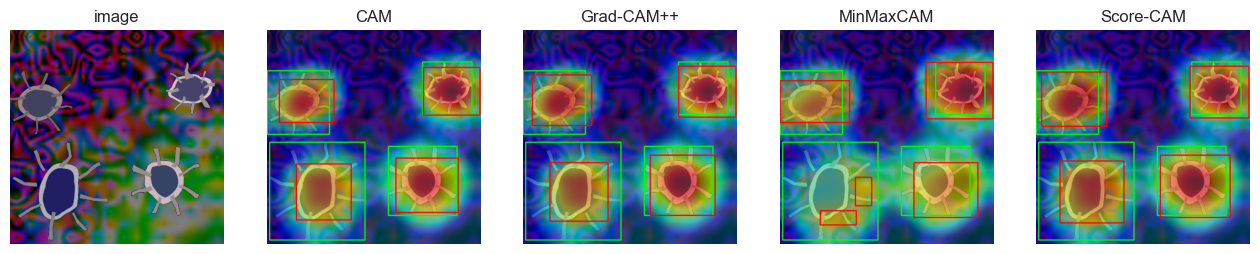

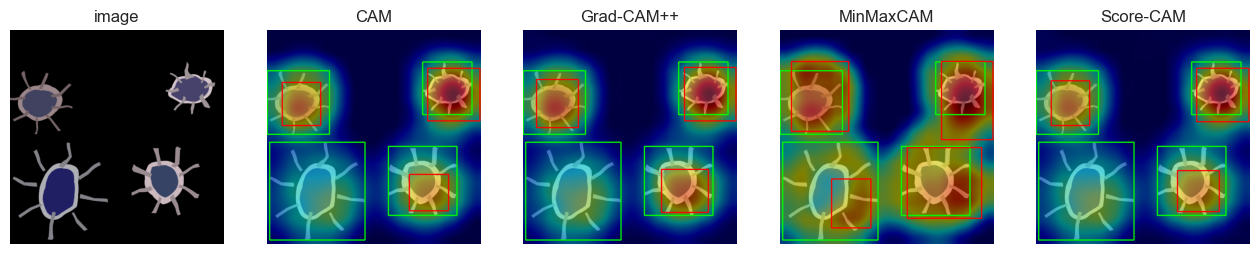

In [112]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image

image_id = 10
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'SYNTHETIC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol2_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
df = mlflow_get_runs(experiment_name, conditions)
df.loc[:, 'artifact_uri'] = df['artifact_uri'].str.removeprefix('file://')

speclist = sorted(df['tags.dataset_spec'].unique())
for spec in speclist:
    df_spec = df.loc[df['tags.dataset_spec'] == spec]
    df_spec = df_spec.loc[:, ['tags.method', 'tags.dataset_spec', 'artifact_uri']]
    df_spec = df_spec.sort_values('tags.method')
    spec_dict = df_spec.set_index('tags.method').to_dict()
    uris = spec_dict['artifact_uri']
    spec = '_'.join(list(spec))
    filebase = f'SYNTHETIC_{spec}_test_{image_id}'
    file_img = filebase + '_img_0.png'
    file_ann = filebase + '_ann_0.png'
    file_cam = filebase + '_cam_0.png'
    file_seg = filebase + '_seg_0.png'
    path_img_orig = os.path.join(f'/Users/goemaereg/github.com/thesis/data/dataset/SYNTHETIC/{spec}/{split}/SYNTHETIC_{spec}_{split}_{image_id}.png')
    _, axes = plt.subplots(1, len(uris) + 1, figsize=(16, 8))
    img = read_image(path=path_img_orig)
    axes[0].imshow(to_pil_image(img))
    axes[0].axis('off')
    axes[0].set_title('image')
    for i, (method, uri) in enumerate(uris.items()):
        path_img = os.path.join(uri, 'xai', split, file_ann)
        img = read_image(path=path_img)
        axes[i+1].imshow(to_pil_image(img))
        axes[i+1].axis('off')
        axes[i+1].set_title(labels_methods[method])
    plt.show()

## ImageNet - VGG16-GAP

In [109]:
metrics = None
metric_name = 'Metrics'
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'ILSVRC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=metrics, caption=caption, label=label)

\begin{table}[ht]
\caption{Metrics for VGG16-GAP on ImageNet}
\label{tb:metrics_vgg16_imagenet}
\begin{tabular}{lrrrr}
\toprule
method & MaxBoxAcc & MaxBoxAccV2 & MaxBoxAccV3_precision & MaxBoxAccV3_recall \\
\midrule
CAM & 61.19 & 60.22 & 36.73 & 38.44 \\
Grad-CAM++ & 61.29 & 60.43 & 36.87 & 38.66 \\
Score-CAM & 58.44 & 57.56 & 37.33 & 36.48 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{Metrics for VGG16-GAP on ImageNet}
\label{tb:metrics_vgg16_imagenet}
\begin{tabular}{lrrr}
 & MaxBoxAcc & MaxBoxAccV2 & MaxBoxAccV3_precision & MaxBoxAccV3_recall \\
method &  &  &  &  \\
CAM & 61.19 & 60.22 & \color{purple} \bfseries 36.73 & 38.44 \\
Grad-CAM++ & \color{teal} \bfseries 61.29 & \color{teal} \bfseries 60.43 & 36.87 & \color{teal} \bfseries 38.66 \\
Score-CAM & \color{purple} \bfseries 58.44 & \color{purple} \bfseries 57.56 & \color{teal} \bfseries 37.33 & \color{purple} \bfseries 36.48 \\
\end{tabular}
\end{table}



In [38]:
def get_class_labels(split='val'):
    """
    image_ids.txt has the structure

    <path>,<integer_class_label>
    path/to/image1.jpg,0
    path/to/image2.jpg,1
    path/to/image3.jpg,1
    ...
    """
    class_labels = {}
    path = f'/Users/goemaereg/github.com/thesis/data/metadata/ILSVRC/{split}/class_labels.txt'
    with open(path) as f:
        for line in f.readlines():
            image_id, class_label_string = line.strip('\n').split(',')
            class_labels[image_id] = int(class_label_string)
    return class_labels

def get_label_names():
    label_names = {}
    with open('/Users/goemaereg/github.com/thesis/other/imagenet1000/imagenet1000_clsidx_to_labels.txt', 'r') as fp:
        for line in fp.readlines():
            label, name = line[:-1].split(':')
            label = label.strip()
            name = name.strip()[1:-2]
            # remove alternative names
            name = name.split(',')[0]
            label_names[label] = name
    return label_names

In [39]:
class_labels = get_class_labels()
label_names = get_label_names()

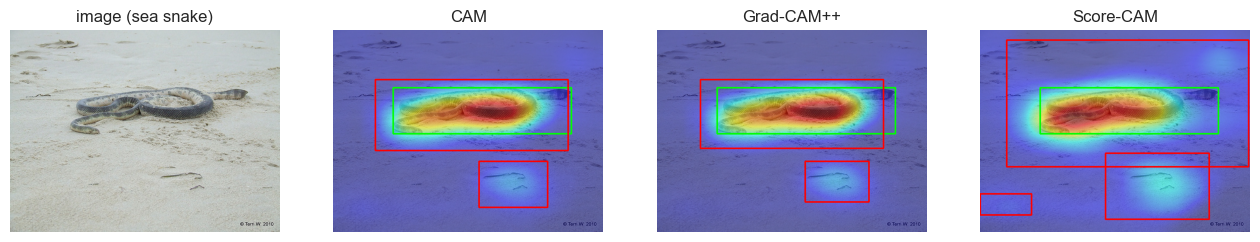

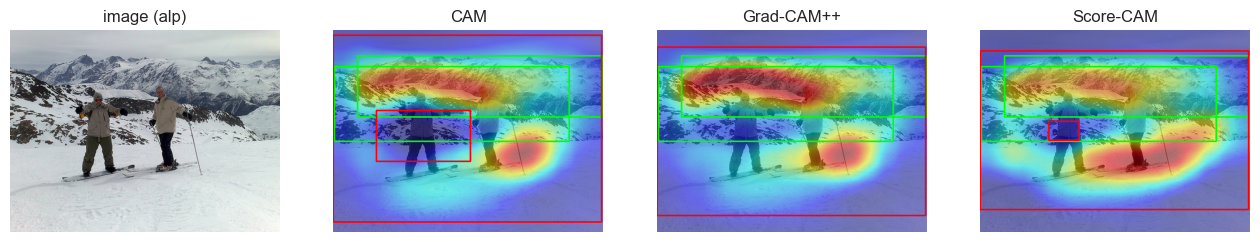

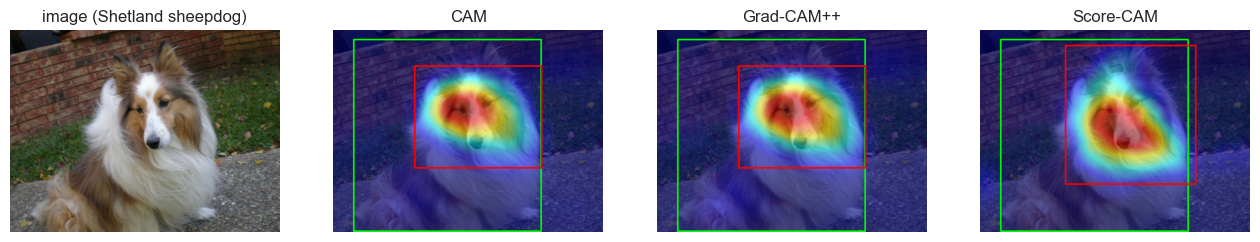

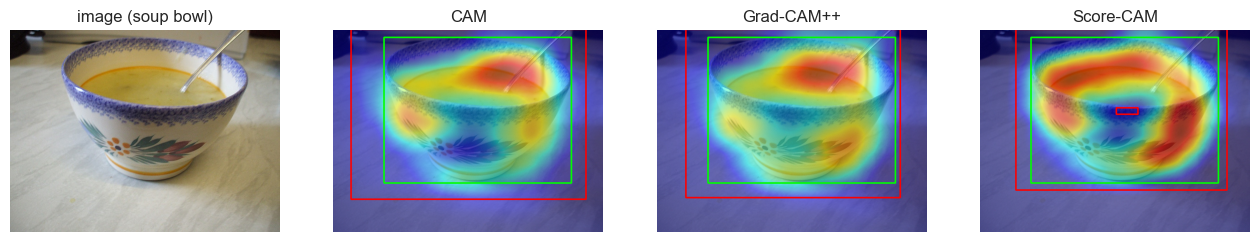

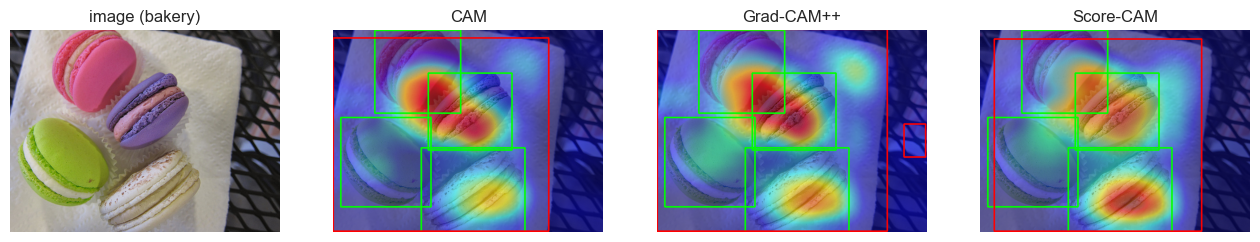

In [41]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image

image_no_list = list(range(1,21))
image_no_list = [1,2,3,4,8]
arch = 'vgg16'
arch_type = 'cam'
network = 'VGG16-GAP'
dataset = 'ILSVRC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
iter = 0
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
df = mlflow_get_runs(experiment_name, conditions)
df = df.loc[df['tags.method'] != 'minmaxcam'] # filter out minmaxcam network was not trained sufficiently
df.loc[:, 'artifact_uri'] = df['artifact_uri'].str.removeprefix('file://')

speclist = sorted(df['tags.dataset_spec'].unique())
for spec in speclist:
    df_spec = df.loc[df['tags.dataset_spec'] == spec]
    df_spec = df_spec.loc[:, ['tags.method', 'tags.dataset_spec', 'artifact_uri']]
    df_spec = df_spec.sort_values('tags.method')
    spec_dict = df_spec.set_index('tags.method').to_dict()
    uris = spec_dict['artifact_uri']
    spec = '_'.join(list(spec))
    for image_no in image_no_list:
        filebase = f'ILSVRC2012_{split}_{image_no:0>8}'
        file_img = filebase + f'_img_{iter}.png'
        file_ann = filebase + f'_ann_{iter}.png'
        file_cam = filebase + f'_cam_{iter}.png'
        file_seg = filebase + f'_seg_{iter}.png'
        image_id = f'{split}/ILSVRC2012_{split}_{image_no:0>8}.JPEG'
        path_img_orig = os.path.join(f'/Users/goemaereg/github.com/thesis/data/dataset/ILSVRC/{image_id}')
        _, axes = plt.subplots(1, len(uris) + 1, figsize=(16, 8))
        img = read_image(path=path_img_orig)
        axes[0].imshow(to_pil_image(img))
        axes[0].axis('off')
        class_id = class_labels[image_id]
        label_name = label_names[str(class_id)]
        axes[0].set_title(f'image ({label_name})')
        for i, (method, uri) in enumerate(uris.items()):
            path_img = os.path.join(uri, 'xai', split, file_ann)
            img = read_image(path=path_img)
            axes[i+1].imshow(to_pil_image(img))
            axes[i+1].axis('off')
            axes[i+1].set_title(labels_methods[method])
        plt.show()

## ImageNet - ResNet-50

In [42]:
metrics = None
metric_name = 'Metrics'
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'ILSVRC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment_name = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
caption=f'{metric_name} for {network} on {dataset_name}'
label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower()
conditions = {
    'tags.dataset': dataset,
    'tags.architecture': arch,
    'tags.architecture_type': arch_type,
    'status': 'FINISHED'
}
mlflow_runs_to_latex(experiment_name, conditions=conditions, split=split, metrics=metrics, caption=caption, label=label)

\begin{table}[ht]
\caption{Metrics for ResNet-50 on ImageNet}
\label{tb:metrics_resnet50_imagenet}
\begin{tabular}{lrrrr}
\toprule
method & MaxBoxAcc & MaxBoxAccV2 & MaxBoxAccV3_precision & MaxBoxAccV3_recall \\
\midrule
CAM & 57.60 & 57.25 & 30.55 & 36.58 \\
Grad-CAM++ & 59.40 & 58.55 & 31.17 & 37.53 \\
MinMaxCAM & 58.81 & 57.26 & 43.70 & 36.02 \\
Score-CAM & 56.19 & 56.35 & 29.60 & 35.92 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{Metrics for ResNet-50 on ImageNet}
\label{tb:metrics_resnet50_imagenet}
\begin{tabular}{lrrr}
 & MaxBoxAcc & MaxBoxAccV2 & MaxBoxAccV3_precision & MaxBoxAccV3_recall \\
method &  &  &  &  \\
CAM & 57.60 & 57.25 & 30.55 & 36.58 \\
Grad-CAM++ & \color{teal} \bfseries 59.40 & \color{teal} \bfseries 58.55 & 31.17 & \color{teal} \bfseries 37.53 \\
MinMaxCAM & 58.81 & 57.26 & \color{teal} \bfseries 43.70 & 36.02 \\
Score-CAM & \color{purple} \bfseries 56.19 & \color{purple} \bfseries 56.35 & \color{purple} \bfseries 29.60 & \co

In [ ]:
experiment_name = 'mwsol_resnet50_imagenet'
conditions = {
    'tags.dataset': 'ILSVRC',
    'tags.architecture': 'resnet50',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
boxacc, prcurve = get_mlflow_boxacc_prcurve(experiment_name=experiment_name, conditions=conditions, split='val', box_metric='MaxBoxAccV3', mask_metric=None)
# BoxAcc
title = f"ResNet-50 ImageNet BoxAcc"
plot_boxacc(boxacc, title=title, iou_thresholds=[50])
if prcurve is not None:
    # PR Curve
    title = f"ResNet-50 ImageNet PR Curve"
    plot_prcurve(prcurve, title)

In [ ]:
dataset = 'SYNTHETIC'
spec = 'd1b'
archtype = 'cam'
experiment_name = 'mwsol_resnet50_synthetic'
run_name = 'resnet50_minmaxcam_synthetic_d1b'
conditions = {
    'tags.dataset': dataset, 'tags.dataset_spec': spec, 'tags.architecture_type': archtype, 'tags.method': 'minmaxcam'}
iou_boxacc, _ = get_mlflow_boxacc_prcurve(experiment_name=experiment_name, conditions=conditions, split='test')

In [ ]:
list(iou_boxacc)

In [ ]:
for method, iou_values in iou_boxacc.items():
    for iou_threshold, boxacc in iou_values.items():
        label = f'{method} {iou_threshold}'
        plt.plot(boxacc['cam_threshold'], boxacc['box_accuracy'], label = label)
plt.xlabel("CAM threshold")
plt.ylabel("BoxAcc")
plt.title('BoxAcc at varying CAM thresholds')
plt.legend()
plt.show()

### Training performance

In [ ]:
dataset = 'SYNTHETIC'
spec = 'd1b'
archtype = 'cam'
experiment_name = 'wsol_resnet50_synthetic'
run_name = 'resnet50_minmaxcam_synthetic_d1b'
# run_id = '63fa71e18f4849a19f49b2923adf57a3'
# run_id = 'e6f2d6ba4ca24e31ba7b57c2e2d0266b'
conditions = {'tags.mlflow.runName': run_name}
runs = mlflow_get_runs(experiment_name, conditions=conditions)

In [ ]:
runs

### Classification versus localization accuracy

In [ ]:
from mlflow import MlflowClient

run_id = runs['run_id'][0]
client = MlflowClient()
val_accuracy = [metric.value for metric in client.get_metric_history(run_id, 'val_accuracy')]
steps = list(range(len(val_accuracy)))
val_maxboxaccv3 = [metric.value for metric in client.get_metric_history(run_id, 'val_MaxBoxAccV3')]
val_pxap = [metric.value for metric in client.get_metric_history(run_id, 'val_PxAP')]

In [ ]:
plt.plot(steps, val_maxboxaccv3, label = 'MaxBoxAccV3')
plt.plot(steps, val_accuracy, label='Classification accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Classification versus localization performance')
plt.legend()
plt.show()

In [ ]:
df

In [ ]:
data = df.loc[df['method'] == 'cam']
data = data.sort_values('dataset')
g = sns.FacetGrid(data, col="dataset", hue="metric", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()

In [ ]:
data = df.loc[df['method'] == 'minmaxcam']
data = data.sort_values('dataset')
g = sns.FacetGrid(data, col="dataset", hue="metric", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()

In [ ]:
dataset = 'SYNTHETIC'
archtype = 'cam'
experiment_name = 'wsol_vgg16_synthetic'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture_type': archtype,
    'tags.train': 'True'
}
df = mlflow_get_runs(experiment_name, conditions=conditions)
cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec', 'metrics.val_accuracy', 'metrics.val_MaxBoxAccV3', 'start_time']
cols_renamed = ['run_id', 'method', 'dataset', 'accuracy', 'MaxBoxAccV3', 'start_time']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
# filter out older minmaxcam training runs
df = df.drop(columns='start_time')
df = df.assign(epochs=epoch_steps, accuracy=epoch_val_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']

In [ ]:
data = df.loc[df['method'] == 'cam']
data = data.sort_values('dataset')
g = sns.FacetGrid(data, col="dataset", hue="metric", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()

In [ ]:
data = df.loc[df['method'] == 'minmaxcam']
data = data.sort_values('dataset')
g = sns.FacetGrid(data, col="dataset", hue="metric", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()

In [ ]:
dataset = 'SYNTHETIC'
archtype = 'vanilla'
experiment_name = 'wsol_vgg16_synthetic'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture_type': archtype,
    'tags.train': 'True'
}
df = mlflow_get_runs(experiment_name, conditions=conditions)
cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec', 'metrics.val_accuracy', 'metrics.val_MaxBoxAccV3', 'start_time']
cols_renamed = ['run_id', 'method', 'dataset', 'accuracy', 'MaxBoxAccV3', 'start_time']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
# filter out older minmaxcam training runs
df = df.drop(columns='start_time')
df = df.assign(epochs=epoch_steps, accuracy=epoch_val_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']
data = df.loc[df['method'] == 'gradcam']
data = data.sort_values('dataset')
g = sns.FacetGrid(data, col="dataset", hue="metric", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()x

In [ ]:
dataset = 'SYNTHETIC'
archtype = 'cam'
experiment_name = 'mwsol2_vgg16_synthetic'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture_type': archtype,
    'tags.method': 'cam',
    'tags.train': 'True'
}
df = mlflow_get_runs(experiment_name, conditions=conditions)
cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec', 'metrics.val_accuracy', 'metrics.val_MaxBoxAccV3', 'start_time']
cols_renamed = ['run_id', 'method', 'dataset', 'accuracy', 'MaxBoxAccV3', 'start_time']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
# filter out older minmaxcam training runs
df = df.loc[(df['method']=='cam') | (df['method']=='minmaxcam')&(df['start_time']>'2023-03-01')]
df = df.drop(columns='start_time')
df = df.assign(epochs=epoch_steps, accuracy=epoch_val_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']

data = df.sort_values('dataset')
g = sns.FacetGrid(data, col="dataset", hue="metric", col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()

In [ ]:
dataset = 'SYNTHETIC'
archtype = 'cam'
experiment_name = 'mwsol2_vgg16_synthetic'
conditions = {
    'tags.dataset': dataset,
    'tags.architecture_type': archtype,
    'tags.method': 'minmaxcam',
    'tags.train': 'True'
}
df = mlflow_get_runs(experiment_name, conditions=conditions)
cols_mlflow = ['run_id', 'tags.method', 'tags.dataset_spec', 'metrics.val_accuracy', 'metrics.val_MaxBoxAccV3', 'start_time']
cols_renamed = ['run_id', 'method', 'dataset', 'accuracy', 'MaxBoxAccV3', 'start_time']
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
# filter out older minmaxcam training runs
df = df.loc[(df['method']=='cam') | (df['method']=='minmaxcam')&(df['start_time']>'2023-03-01')]
df = df.drop(columns='start_time')
df = df.assign(epochs=epoch_steps, accuracy=epoch_val_accuracy, MaxBoxAccV3=epoch_maxboxaccv3)
df = df.explode(column=['epochs', 'accuracy', 'MaxBoxAccV3'])
df = df.drop(columns='run_id').set_index(['method','dataset','epochs']).stack().reset_index()
df.columns = ['method','dataset','epochs','metric','values']

data = df.sort_values('dataset')
g = sns.FacetGrid(data, col="dataset", hue="metric", col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(sns.lineplot, x="epochs", y="values")
g.add_legend()

In [ ]:
train_accuracy = [metric.value for metric in client.get_metric_history(run_id, 'train_accuracy')]
plt.plot(steps, train_accuracy, label='train accuracy')
plt.plot(steps, val_accuracy, label='val accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Training versus validation classification accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(steps, val_maxboxaccv3, label = 'MaxBoxAccV3')
plt.plot(steps, val_accuracy, label='Classification accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Classification versus localization performance')
plt.legend()
plt.show()

### Iterative localization

In [ ]:
experiment_name = 'mwsol_vgg16_synthetic_iter'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.dataset_spec': 'd4b',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'tags.method': 'cam',
    'status': 'FINISHED'
}
# conditions |= {
#     'params.bbox_mask_strategy': 'random',
#     'params.bbox_merge_strategy': 'add',
#     'params.iter_stop_prob_delta': '0.25',
# }
df_runs = mlflow_get_runs(experiment_name, conditions)

In [ ]:
import itertools
import numpy as np

label = 'tab:iter_metrics_vgg16_cam_synthetic'
caption = 'Iterative CAM localization metrics for VGG16-GAP on synthetic dataset'
metrics = ['MaxBoxAccV3_recall', 'MaxBoxAccV3_precision', 'MaxBoxAccV3_f1']
metrics_short = ['recall','precision','f1']
split = 'test'

df = df_runs
cols_metrics_mlflow = [f'metrics.{split}_{metric}' for metric in metrics]
cols_params = ['bbox_mask_strategy', 'bbox_merge_strategy', 'iter_stop_prob_delta']
cols_params_mlflow = [f'params.{p}' for p in cols_params]
cols_mlflow = ['tags.method', 'tags.architecture', 'tags.architecture_type', 'tags.dataset', 'tags.dataset_spec']
cols_mlflow += cols_metrics_mlflow + cols_params_mlflow
cols_renamed = [c.split('.')[-1] for c in cols_mlflow]
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
mapper = dict([(f'{split}_{metric}', metric) for metric in metrics])
df = df.rename(columns=mapper)
mapper = dict(zip(metrics, metrics_short))
df = df.rename(columns=mapper)
cols_params_short = ['mask', 'merge', 'stop']
mapper = dict(zip(cols_params, cols_params_short))
df = df.rename(columns=mapper)
# df.loc[:, 'dataset'] = df['dataset'].str.cat(df['dataset_spec'], sep='\_').str.lower()
# pd.set_option("display.precision", 2)
metrics = metrics_short
for metric in metrics:
    df[metric] *= 100 # to percentage
cols_filter = cols_params_short + metrics
df = df.loc[:, cols_filter]
cols_pivot = ['merge']
cols_index = ['stop', 'mask']
pivot_values = [np.sort(df.loc[:, c].unique()).tolist() for c in cols_pivot]
df = df.pivot(index=cols_index, columns=cols_pivot, values=metrics)
iterables = [metrics]
cols_format = dict([(col_index, '{:.2f}') for col_index in itertools.product(metrics, *pivot_values)])
s = df.style
s = s.format(cols_format)
s = s.highlight_max(subset=metrics, axis=0, props='color:{teal}; bfseries: ;')
s = s.highlight_min(subset=metrics, axis=0, props='color:{purple}; bfseries: ;')
latex_table = s.to_latex(
        # column_format="llll" + "r"*len(metrics),
        position="ht", position_float="centering",
        hrules=False, label=label, caption=caption,
        multirow_align="t", multicol_align="c")
print(latex_table)

In [ ]:
import itertools
import numpy as np

label = 'tab:iter_metrics_vgg16_cam_synthetic'
caption = 'Iterative CAM localization metrics for VGG16-GAP on synthetic dataset'
metrics = ['MaxBoxAccV3_recall', 'MaxBoxAccV3_precision', 'MaxBoxAccV3_f1']
metrics_short = ['recall','precision','f1']
split = 'test'

df = df_runs
cols_metrics_mlflow = [f'metrics.{split}_{metric}' for metric in metrics]
cols_params = ['bbox_mask_strategy', 'bbox_merge_strategy', 'iter_stop_prob_delta']
cols_params_mlflow = [f'params.{p}' for p in cols_params]
cols_mlflow = ['tags.method', 'tags.architecture', 'tags.architecture_type', 'tags.dataset', 'tags.dataset_spec']
cols_mlflow += cols_metrics_mlflow + cols_params_mlflow
cols_renamed = [c.split('.')[-1] for c in cols_mlflow]
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)
mapper = dict([(f'{split}_{metric}', metric) for metric in metrics])
df = df.rename(columns=mapper)
mapper = dict(zip(metrics, metrics_short))
df = df.rename(columns=mapper)
cols_params_short = ['mask', 'merge', 'stop']
mapper = dict(zip(cols_params, cols_params_short))
df = df.rename(columns=mapper)
# df.loc[:, 'dataset'] = df['dataset'].str.cat(df['dataset_spec'], sep='\_').str.lower()
# pd.set_option("display.precision", 2)
metrics = metrics_short
for metric in metrics:
    df[metric] *= 100 # to percentage
cols_filter = cols_params_short + metrics
df = df.loc[:, cols_filter]
cols_pivot = ['merge']
cols_index = ['stop', 'mask']
pivot_values = [np.sort(df.loc[:, c].unique()).tolist() for c in cols_pivot]
df = df.pivot(index=cols_index, columns=cols_pivot, values=metrics)
cols_format = dict([(col_index, '{:.2f}') for col_index in itertools.product(metrics, *pivot_values)])
s = df.style
s = s.format(cols_format)
s = s.highlight_max(subset=metrics, axis=0, props='color:{teal}; bfseries: ;')
s = s.highlight_min(subset=metrics, axis=0, props='color:{purple}; bfseries: ;')
latex_table = s.to_latex(
        # column_format="llll" + "r"*len(metrics),
        position="ht", position_float="centering",
        hrules=False, label=label, caption=caption,
        multirow_align="t", multicol_align="c")
print(latex_table)

In [ ]:
experiment_name = 'mwsol_vgg16_synthetic_iter'
split = 'test'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
# conditions |= {'tags.dataset_spec': 'd4b'}
# conditions |= {
#     'params.bbox_mask_strategy': 'mean',
#     'params.bbox_merge_strategy': 'unify',
#     'params.iter_stop_prob_delta': '0.5',
# }

df = mlflow_get_runs(experiment_name, conditions)

label = 'tab:iter_metrics_vgg16_cam_synthetic'
caption = 'Iterative localization metrics for VGG16-GAP on synthetic dataset'
cols_metrics = ['MaxBoxAccV3_recall', 'MaxBoxAccV3_precision', 'MaxBoxAccV3_f1']
cols_metrics_mlflow = [f'metrics.{split}_{metric}' for metric in cols_metrics]
cols_metrics_short = ['recall','precision','f1']
cols_params = ['bbox_mask_strategy', 'bbox_merge_strategy', 'iter_stop_prob_delta']
cols_params_mlflow = [f'params.{p}' for p in cols_params]
cols_params_short = ['mask', 'merge', 'stop']
cols_tags_mlflow = ['tags.method', 'tags.dataset_spec']
cols_tags_short = ['method', 'dataset']

cols_mlflow = cols_tags_mlflow + cols_params_mlflow + cols_metrics_mlflow
cols_renamed = cols_tags_short + cols_params_short + cols_metrics_short
mapper = dict(zip(cols_mlflow, cols_renamed))
df = df.loc[:, cols_mlflow].rename(columns=mapper)

metrics = cols_metrics_short
for metric in metrics:
    df[metric] *= 100 # to percentage

In [ ]:
df

In [ ]:
# baseline without iteration
experiment_name = 'mwsol_vgg16_synthetic'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
split = 'test'
df_base = mlflow_get_runs(experiment_name, conditions)
cols = ['tags.method', 'tags.dataset_spec',
        f'metrics.{split}_MaxBoxAccV3_f1', f'metrics.{split}_MaxBoxAccV3_precision', f'metrics.{split}_MaxBoxAccV3_recall']
cols_renamed = ['method', 'spec', 'f1', 'precision', 'recall']
df_base = df_base.loc[:, cols]
df_base = df_base.rename(columns=dict(zip(cols, cols_renamed)))
prec_base = df_base.set_index(['spec', 'method']).to_dict()

# iterative experiments
experiment_name = 'mwsol_vgg16_synthetic_iter'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
# conditions |= {
#     'params.bbox_mask_strategy': 'random',
#     'params.bbox_merge_strategy': 'add',
#     'params.iter_stop_prob_delta': '0.25',
# }
df = mlflow_get_runs(experiment_name, conditions)
cols = ['tags.method', 'tags.dataset_spec',
        'params.bbox_mask_strategy', 'params.bbox_merge_strategy', 'params.iter_stop_prob_delta',
        f'metrics.{split}_MaxBoxAccV3_f1', f'metrics.{split}_MaxBoxAccV3_precision', f'metrics.{split}_MaxBoxAccV3_recall']
cols_renamed = ['method', 'spec',
                'mask', 'merge', 'stop',
                'f1', 'precision', 'recall']
mapper = dict(zip(cols, cols_renamed))
df = df.loc[:, cols].rename(columns=mapper)
df = df.replace({'method': labels_methods})
for metric in ['precision', 'recall', 'f1']:
    df[metric] *= 100 # to percentage
df = df.sort_values(['method', 'spec'])
for spec in [f'd{i}b' for i in range(1,5)]:
    df2 = df.loc[(df['spec'] == spec)]
    sns.set_style("darkgrid")
    sns.set_context("paper")
    markers = {'drop': 'v', 'add': '^', 'unify':'o'}
    sizes = {'0.25': 50, '0.5': 100, '1.0': 150}
    size_order = ['0.25', '0.5', '1.0']
    hue_order = ['mean','random','zero']
    sns_fig = sns.relplot(data=df2, x="recall", y="precision", hue="mask", style="merge",
                          size="stop", size_order=size_order, col='method', col_wrap=2,
                          markers=markers, sizes=sizes, hue_order=hue_order, alpha=0.5)
    sns.move_legend(sns_fig, loc='center right', bbox_to_anchor=(1.02, 0.5), labelspacing=1.0, frameon=True)

    # flatten axes into a 1-d array
    axes = sns_fig.axes.flatten()
    # iterate through the axes
    methods = ['cam', 'gradcam++', 'minmaxcam', 'scorecam']
    for i, ax in enumerate(axes):
        method = methods[i]
        precision = prec_base['precision'][(spec, method)] * 100
        recall = prec_base['recall'][(spec, method)] * 100
        line_prec = ax.axhline(precision, ls='--', c='purple', label='precision', alpha=0.5)
        line_rec = ax.axvline(recall, ls='--', c='teal', label='recall', alpha=0.5)
        if i == 1:
            lines = [line_prec, line_rec]
            labels = ['precision', 'recall']
            legend = ax.legend(lines, labels, bbox_to_anchor=(1.02, 1.0), loc='upper left', title='baseline', frameon=True)
    sns_fig.savefig(f'fig_iter_vgg16_gap_syn_{spec}.png')

In [ ]:
# baseline without iteration
experiment_name = 'mwsol_resnet50_imagenet'
conditions = {
    'tags.dataset': 'ILSVRC',
    'tags.architecture': 'resnet50',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
split = 'val'
df_base = mlflow_get_runs(experiment_name, conditions)
df_base = df_base.loc[df_base.start_time > '2023-05-01']
cols = ['tags.method',
        f'metrics.{split}_MaxBoxAccV3_f1', f'metrics.{split}_MaxBoxAccV3_precision', f'metrics.{split}_MaxBoxAccV3_recall']
cols_renamed = ['method', 'f1', 'precision', 'recall']
df_base = df_base.loc[:, cols]
df_base = df_base.rename(columns=dict(zip(cols, cols_renamed)))
prec_base = df_base.set_index(['method']).to_dict()

# iterative experiments
experiment_name = 'mwsol_resnet50_imagenet_iter'
conditions = {
    'tags.dataset': 'ILSVRC',
    'tags.architecture': 'resnet50',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
# conditions |= {
#     'params.bbox_mask_strategy': 'random',
#     'params.bbox_merge_strategy': 'add',
#     'params.iter_stop_prob_delta': '0.25',
# }
df = mlflow_get_runs(experiment_name, conditions)
cols = ['tags.method',
        'params.bbox_mask_strategy', 'params.bbox_merge_strategy', 'params.iter_stop_prob_delta',
        f'metrics.{split}_MaxBoxAccV3_f1', f'metrics.{split}_MaxBoxAccV3_precision', f'metrics.{split}_MaxBoxAccV3_recall']
cols_renamed = ['method',
                'mask', 'merge', 'stop',
                'f1', 'precision', 'recall']
mapper = dict(zip(cols, cols_renamed))
df = df.loc[:, cols].rename(columns=mapper)
df = df.replace({'method': labels_methods})
for metric in ['precision', 'recall', 'f1']:
    df[metric] *= 100 # to percentage
df = df.sort_values(['method'])

sns.set_style("darkgrid")
sns.set_context("paper")
markers = {'drop': 'v', 'add': '^', 'unify':'o'}
# markers = {'drop': 'x', 'add': '+', 'unify':'2'}
sizes = {'0.25': 50, '0.5': 100, '1.0': 150}
size_order = ['0.25', '0.5', '1.0']
hue_order = ['mean','random','zero']
sns_fig = sns.relplot(data=df, x="recall", y="precision", hue="mask", style="merge",
                      size="stop", size_order=size_order, col='method', col_wrap=2,
                      markers=markers, sizes=sizes, hue_order=hue_order, alpha=0.5)
sns.move_legend(sns_fig, loc='center right', bbox_to_anchor=(1.02, 0.5), labelspacing=1.0, frameon=True)
# flatten axes into a 1-d array
axes = sns_fig.axes.flatten()
# iterate through the axes
methods = ['cam', 'gradcam++', 'minmaxcam', 'scorecam']
for i, ax in enumerate(axes):
    method = methods[i]
    precision = prec_base['precision'][method] * 100
    recall = prec_base['recall'][method] * 100
    line_prec = ax.axhline(precision, ls='--', c='purple', label='precision', alpha=0.5)
    line_rec = ax.axvline(recall, ls='--', c='teal', label='recall', alpha=0.5)
    if i == 1:
        lines = [line_prec, line_rec]
        labels = ['precision', 'recall']
        legend = ax.legend(lines, labels, bbox_to_anchor=(1.02, 1.0), loc='upper left', title='baseline', frameon=True)
sns_fig.savefig(f'fig_iter_resnet50_imagenet.png')

In [ ]:
experiment_name = 'mwsol2_vgg16_synthetic'
conditions = {
    'tags.dataset': 'SYNTHETIC',
    'tags.architecture': 'vgg16',
    'tags.architecture_type': 'cam',
    'status': 'FINISHED'
}
df = mlflow_get_runs(experiment_name, conditions)
run_ids = df['run_id']
artifact_uris = df['artifact_uri']
run_names = df['tags.mlflow.runName']
run_id = run_ids
artifact_uri = artifact_uris
# run = mlflow.get_run(run_id)
for run_id, run_name, artifact_uri in zip(run_ids, run_names, artifact_uris):
    training_json = mlflow.artifacts.load_dict(artifact_uri[5:] + "/state/training.json")
    print(f'{run_name}: {training_json["epochs_trained"]}/{training_json["epochs_planned"]} epochs')


In [ ]:
training_json

In [ ]:
df